<h1>Часть text recognition:</h1>

архитектура CRNN и loss func CTC

In [2]:
import torch
import torch.nn as nn
import os
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
import torchvision.transforms as transforms
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
import numpy as np
from tqdm import tqdm
from torch.autograd import Variable

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/text_rec_data

/content/drive/MyDrive/text_rec_data


Данные не заливались папкой на диск, пришлось архивировать и разархивировать в среде и уменьшить размер в 2 раза, иначе os.listdir() не может считать все файлы и выдает ошибку

In [ ]:
!unzip /content/drive/MyDrive/text_rec_data/lines_w25.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: lines_w25/20153_a.png   
  inflating: __MACOSX/lines_w25/._20153_a.png  
  inflating: lines_w25/25735_a.png   
  inflating: __MACOSX/lines_w25/._25735_a.png  
  inflating: lines_w25/37916_a.png   
  inflating: __MACOSX/lines_w25/._37916_a.png  
  inflating: lines_w25/1915_a.png    
  inflating: __MACOSX/lines_w25/._1915_a.png  
  inflating: lines_w25/24274_b.gt.txt  
  inflating: __MACOSX/lines_w25/._24274_b.gt.txt  
  inflating: lines_w25/30617_a.gt.txt  
  inflating: __MACOSX/lines_w25/._30617_a.gt.txt  
  inflating: lines_w25/19196_a.png   
  inflating: __MACOSX/lines_w25/._19196_a.png  
  inflating: lines_w25/21955_a.png   
  inflating: __MACOSX/lines_w25/._21955_a.png  
  inflating: lines_w25/42726_b.gt.txt  
  inflating: __MACOSX/lines_w25/._42726_b.gt.txt  
  inflating: lines_w25/26406_a.png   
  inflating: __MACOSX/lines_w25/._26406_a.png  
  inflating: lines_w25/23260_a.png   
  inflating: __MACOS

Сбор путей до изображений и их текстов. +1 делается, так как в папке есть лишний файл на первом месте = .DS_store.

In [ ]:
path = '/content/drive/MyDrive/text_rec_data/lines_w25/'
file_paths = os.listdir(path)
file_paths.sort()
label_paths = []
img_paths = []
for i in range(1, len(file_paths)-1, 2):
  #print(file_paths[i], file_paths[i+1])
  label_paths.append(file_paths[i])
  try:
    img_paths.append(file_paths[i+1])
  except:
    print('len of file_paths:',len(file_paths), 'i+1=',i+1)

In [ ]:
len(label_paths), len(img_paths)

(98879, 98879)

Кодирование элементов строки

In [ ]:
alphabet = 'аАбБвВгГдДеЕёЁжЖзЗиИйЙкКлЛмМнНоОпПрРсСтТуУфФхХцЦчЧшШщЩъЪыЫьЬэЭюЮяЯ0123456789-.,: !()"?;'

def encode_to_labels(txt):
    dig_lst = []
    for index, char in enumerate(txt):
        try:
            dig_lst.append(alphabet.index(char)+1)
        except:
            print(char)
    return np.array(dig_lst)

def decode_to_string(arr):
  dec_str = ''
  for elem in arr:
    dec_str = dec_str + alphabet[elem-1]
  return dec_str

Кастомный датасет с изображением лейблом и длиной лейбла

In [ ]:
class rec_Dataset(Dataset):

  def __init__(self, img_paths, label_paths, transform_list = None):
    self.img_paths = img_paths
    self.label_paths = label_paths
    self.transform = transforms.Compose(transform_list)

  def __len__(self):
    return len(self.img_paths)

  def __getitem__(self, index):

    img = Image.open('/content/drive/MyDrive/text_rec_data/lines_w25/'+self.img_paths[index])
    #img = cv2.imread('/content/drive/MyDrive/testFolder/'+self.img_paths[index])
    #img = torch.from_numpy(img.transpose((2, 0, 1))).float()
    with open('/content/drive/MyDrive/text_rec_data/lines_w25/'+self.label_paths[index], 'r') as file:
      seq = file.read().replace('\n', '')
      seq = torch.Tensor(encode_to_labels(seq))

    #seq_len = torch.Tensor(len(seq))
    seq_len = len(seq)

    if self.transform is not None:
      img = self.transform(img)

    sample = {"img": img.cuda(), "seq": seq.cuda(), "seq_len": seq_len}

    return sample

Функция для выравнивания текста батча под один размер

In [ ]:
def text_collate(batch):
    img = list()
    seq = list()
    seq_len = list()
    for sample in batch:
        #print(sample["img"])
        img.append(sample["img"])
        seq.extend(sample["seq"])
        seq_len.append(sample["seq_len"])
    img = torch.stack(img)
    seq = torch.Tensor(seq).int()
    seq_len = torch.Tensor(seq_len).int()
    batch = {"img": img, "seq": seq, "seq_len": seq_len}
    return batch

Деление на трейн и валидацию и возвращаем сразу готовые dataloader's в нужной пропорции

In [ ]:
def get_loaders(img_paths, label_paths, train_size = 75, btch_size = 256):
    
  data_transf = [transforms.Grayscale(1),
                 transforms.ToTensor(),
                 transforms.Resize((32, 128)),
                 transforms.Normalize(0.5, 0.25)]
  dataset = rec_Dataset(img_paths, label_paths, data_transf)

  train_size = (len(dataset)*train_size)//100
  val_size = len(dataset) - train_size
  train_data, val_data = random_split(dataset, [train_size, val_size])

  train_loader = DataLoader(train_data, batch_size = btch_size, shuffle = True, collate_fn=text_collate)
  val_loader = DataLoader(val_data,  batch_size = btch_size, shuffle = False, collate_fn=text_collate)

  return train_loader, val_loader

In [ ]:
train_loader, val_loader = get_loaders(img_paths, label_paths)

Испольуем слой двухнаправленного LSTM  в связке с CRNN

In [3]:
class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()

        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)

    def forward(self, input):
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)

        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)
        return output

In [4]:
class CRNN_LSTM(nn.Module):

  def __init__(self, imgH = 32, nc = 1, nclass = 88, nh = 256 ):
    super(CRNN_LSTM, self).__init__()
    #
    assert imgH % 16 == 0, 'imgH has to be a multiple of 16'

    self.conv1 = nn.Conv2d(nc, 64, 3, 1, 1)
    self.relu = nn.ReLU(True)
    self.pool = nn.MaxPool2d(2)

    self.conv2 = nn.Conv2d(64, 128, 3, 1, 1)

    self.conv3_1 = nn.Conv2d(128, 256, 3, 1, 1)
    self.bn3 = nn.BatchNorm2d(256)
    self.conv3_2 = nn.Conv2d(256, 256, 3, 1, 1)
    
    self.pool_34 = nn.MaxPool2d((2, 2), (2, 1), (0, 1))

    self.conv4_1 = nn.Conv2d(256, 512, 3, 1, 1)
    self.conv4_2 = nn.Conv2d(512, 512, 3, 1, 1)

    self.bn_45 = nn.BatchNorm2d(512)

    self.conv5 = nn.Conv2d(512, 512, 2, 1, 0)

    self.rnn = nn.Sequential(BidirectionalLSTM(512, nh, nh),
                             BidirectionalLSTM(nh, nh, nclass))
    
  def forward(self, input):

    x = self.pool(self.relu(self.conv1(input)))
    x = self.pool(self.relu(self.conv2(x)))
    x = self.pool_34(self.relu(self.conv3_2(self.relu(self.bn3(self.conv3_1(x))))))
    x = self.pool_34(self.relu(self.conv4_2(self.relu(self.bn_45(self.conv4_1(x))))))
    conv = self.relu(self.bn_45(self.conv5(x)))

    b, c, h, w = conv.size()
    assert h == 1, "the height of conv must be 1"

    conv = conv.squeeze(2)
    conv = conv.permute(2, 0, 1)  # [w, b, c]

    output = self.rnn(conv)

    return output

Функция обучения, где перед подачей преобразуем все нужные переменные для лосса в правильный формат и передаем для подсчета, после скейлер передает значения и оптимизирует параметры

In [ ]:
def train_fun(loader, model, optimizer, loss_func, scaler):
  batch_size = loader.batch_size
  iterator = tqdm(loader)

  device_2use = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  for sample in iterator:

    imgs = Variable(sample['img']).to(device_2use)
    label = Variable(sample['seq'].view(-1))
    label_len = Variable(sample['seq_len'])

    with torch.cuda.amp.autocast():
      predictions = model(imgs)
      log_probs = predictions.log_softmax(2).requires_grad_()
      #preds_size = Variable(torch.IntTensor([predictions.size(0)] * batch_size))
      input_lengths=Variable( torch.full((log_probs.shape[1],), log_probs.shape[0], dtype=torch.long) )

      loss = loss_func(log_probs, label, input_lengths, label_len)

    # backward
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    # update tqdm loop
    iterator.set_postfix(loss=loss.item())

Адам оптимизатор как самый популярный выбор на равне с SGD, ресурсы не позволяли эксперименты с более верным, так как не осталось аккаунтов, с возможностью работать в колабе на ГПУ. Запускал на 100 эпох, но ресурсы закончились примерно на 50ой эпохе

In [ ]:
device_2use = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#tensor = torch.tensor.cuda()
model = CRNN_LSTM().to(device_2use)
loss_func = nn.CTCLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

scaler = torch.cuda.amp.GradScaler()
save=False

for epoch in range(100):
  train_fun(train_loader, model, optimizer, loss_func, scaler)
  checkpoint = {
      "state_dict": model.state_dict(),
      "optimizer":optimizer.state_dict(),
  }
  if save:
    torch.save(checkpoint, f"/content/drive/MyDrive/checkpoint_ep{epoch}_less_lr.pth.tar")
    print(f"checkpoint_ep{epoch}.pth.tar saved")
    save = False
  else:
    save = True

  5%|▌         | 15/290 [59:03<48:04, 10.49s/it, loss=4.56]  

>
>


  8%|▊         | 23/290 [59:15<08:36,  1.93s/it, loss=3.93]

*
*
*


 10%|█         | 29/290 [59:23<06:25,  1.48s/it, loss=3.74]

[


 13%|█▎        | 38/290 [59:36<06:00,  1.43s/it, loss=3.54]

>


 17%|█▋        | 50/290 [59:54<05:47,  1.45s/it, loss=3.39]

>
>


 21%|██        | 60/290 [1:00:08<05:19,  1.39s/it, loss=3.35]

>
>


 23%|██▎       | 67/290 [1:00:17<05:12,  1.40s/it, loss=3.3]

]


 24%|██▍       | 70/290 [1:00:22<05:03,  1.38s/it, loss=3.31]

]
[
]


 27%|██▋       | 79/290 [1:00:34<04:58,  1.41s/it, loss=3.3]

>


 28%|██▊       | 80/290 [1:00:36<04:53,  1.40s/it, loss=3.29]

*
*
*


 28%|██▊       | 82/290 [1:00:38<04:48,  1.39s/it, loss=3.29]

[
]


 31%|███       | 89/290 [1:00:48<04:45,  1.42s/it, loss=3.27]

]


 40%|████      | 117/290 [1:01:29<04:10,  1.45s/it, loss=3.21]

[


 47%|████▋     | 137/290 [1:01:58<03:44,  1.47s/it, loss=3.19]

*
*
*


 52%|█████▏    | 151/290 [1:02:19<03:33,  1.54s/it, loss=3.17]

*
*
*


 67%|██████▋   | 194/290 [1:03:22<02:19,  1.46s/it, loss=3.15]

>
>
]
[
]


 68%|██████▊   | 196/290 [1:03:25<02:21,  1.51s/it, loss=3.15]

[


 70%|███████   | 204/290 [1:03:37<02:09,  1.51s/it, loss=3.42]

>
>
>


 74%|███████▍  | 215/290 [1:03:54<01:55,  1.54s/it, loss=3.35]

<


 77%|███████▋  | 224/290 [1:04:08<01:39,  1.51s/it, loss=3.25]

>
>


 80%|███████▉  | 231/290 [1:04:18<01:25,  1.45s/it, loss=3.21]

<


 81%|████████  | 235/290 [1:04:24<01:22,  1.49s/it, loss=3.18]

>
>


 84%|████████▍ | 243/290 [1:04:36<01:10,  1.49s/it, loss=3.13]

[
>
>


 84%|████████▍ | 245/290 [1:04:39<01:08,  1.52s/it, loss=3.14]

[
]


 87%|████████▋ | 252/290 [1:04:49<00:56,  1.48s/it, loss=3.09]

>
>


 91%|█████████▏| 265/290 [1:05:09<00:36,  1.45s/it, loss=3.21]

>


 92%|█████████▏| 268/290 [1:05:13<00:32,  1.50s/it, loss=3.1]

[
]


 94%|█████████▍| 272/290 [1:05:19<00:26,  1.49s/it, loss=3.2]

>
>


 97%|█████████▋| 280/290 [1:05:31<00:14,  1.48s/it, loss=3.53]

>
>


 98%|█████████▊| 285/290 [1:05:39<00:07,  1.56s/it, loss=3.75]

[
]


  3%|▎         | 9/290 [00:09<05:07,  1.09s/it, loss=3.19]

>


  4%|▍         | 13/290 [00:14<04:57,  1.08s/it, loss=3.2]

>
>


  7%|▋         | 20/290 [00:21<04:49,  1.07s/it, loss=3.2]

]


  9%|▉         | 27/290 [00:29<04:52,  1.11s/it, loss=3.15]

>
>


 10%|▉         | 28/290 [00:30<04:51,  1.11s/it, loss=3.11]

>
>


 12%|█▏        | 34/290 [00:36<04:38,  1.09s/it, loss=3.13]

*
*
*


 12%|█▏        | 36/290 [00:38<04:37,  1.09s/it, loss=3.09]

>


 15%|█▌        | 44/290 [00:47<04:30,  1.10s/it, loss=3.05]

*
*
*


 16%|█▌        | 47/290 [00:50<04:23,  1.09s/it, loss=3.09]

>
>
>
>


 19%|█▉        | 55/290 [00:59<04:17,  1.10s/it, loss=3.11]

>
>


 27%|██▋       | 78/290 [01:24<03:52,  1.09s/it, loss=3.03]

[


 31%|███       | 90/290 [01:37<03:39,  1.10s/it, loss=3.07]

>
>


 31%|███▏      | 91/290 [01:38<03:37,  1.10s/it, loss=3.05]

<


 32%|███▏      | 94/290 [01:41<03:36,  1.10s/it, loss=3]

[
]


 39%|███▉      | 113/290 [02:02<03:14,  1.10s/it, loss=3.05]

]
[
]


 40%|███▉      | 115/290 [02:04<03:12,  1.10s/it, loss=3]

[


 60%|██████    | 174/290 [03:08<02:03,  1.06s/it, loss=2.96]

[


 69%|██████▉   | 200/290 [03:36<01:38,  1.09s/it, loss=2.94]

*
*
*


 70%|███████   | 204/290 [03:41<01:33,  1.09s/it, loss=2.91]

>
>


 72%|███████▏  | 208/290 [03:45<01:25,  1.05s/it, loss=2.89]

>
>


 76%|███████▌  | 221/290 [03:58<01:13,  1.07s/it, loss=2.81]

*
*
*


 77%|███████▋  | 222/290 [04:00<01:13,  1.08s/it, loss=2.83]

[
]


 78%|███████▊  | 227/290 [04:05<01:09,  1.10s/it, loss=2.79]

>


 79%|███████▉  | 229/290 [04:07<01:05,  1.07s/it, loss=2.74]

<


 90%|█████████ | 262/290 [04:43<00:29,  1.06s/it, loss=2.68]

>
>
[
]


 91%|█████████ | 263/290 [04:44<00:29,  1.08s/it, loss=2.74]

]
[
]
[


 92%|█████████▏| 266/290 [04:47<00:25,  1.05s/it, loss=2.71]

[
]


 93%|█████████▎| 270/290 [04:51<00:20,  1.04s/it, loss=2.67]

]


 98%|█████████▊| 285/290 [05:07<00:05,  1.06s/it, loss=2.65]

>
>
>


100%|██████████| 290/290 [05:12<00:00,  1.08s/it, loss=2.69]


checkpoint_ep1.pth.tar saved


  1%|          | 3/290 [00:03<05:07,  1.07s/it, loss=2.62]

>
>


  3%|▎         | 8/290 [00:08<04:58,  1.06s/it, loss=2.6]

[


 12%|█▏        | 34/290 [00:36<04:30,  1.06s/it, loss=2.7]

>
>


 13%|█▎        | 38/290 [00:40<04:26,  1.06s/it, loss=2.98]

>
>


 15%|█▌        | 44/290 [00:46<04:24,  1.08s/it, loss=2.84]

*
*
*


 20%|█▉        | 57/290 [01:00<04:03,  1.04s/it, loss=2.72]

>
>


 32%|███▏      | 92/290 [01:37<03:27,  1.05s/it, loss=2.62]

]
[
]


 32%|███▏      | 94/290 [01:39<03:29,  1.07s/it, loss=2.63]

[
]


 34%|███▍      | 99/290 [01:45<03:28,  1.09s/it, loss=2.61]

>
>


 42%|████▏     | 122/290 [02:09<02:58,  1.06s/it, loss=2.47]

*
*
*


 47%|████▋     | 135/290 [02:23<02:47,  1.08s/it, loss=2.45]

[
]


 47%|████▋     | 137/290 [02:25<02:45,  1.08s/it, loss=2.43]

>


 48%|████▊     | 138/290 [02:26<02:43,  1.07s/it, loss=2.47]

[


 49%|████▉     | 142/290 [02:31<02:37,  1.06s/it, loss=2.56]

]


 51%|█████     | 147/290 [02:36<02:31,  1.06s/it, loss=2.69]

[
]


 53%|█████▎    | 155/290 [02:45<02:26,  1.08s/it, loss=2.54]

<


 67%|██████▋   | 193/290 [03:26<01:43,  1.06s/it, loss=2.46]

<


 68%|██████▊   | 198/290 [03:31<01:38,  1.07s/it, loss=2.46]

>


 73%|███████▎  | 212/290 [03:46<01:23,  1.07s/it, loss=2.49]

*
*
*


 73%|███████▎  | 213/290 [03:47<01:26,  1.12s/it, loss=2.49]

[
]


 75%|███████▌  | 218/290 [03:53<01:19,  1.10s/it, loss=2.49]

[


 76%|███████▌  | 220/290 [03:55<01:15,  1.09s/it, loss=2.46]

>
>
>


 77%|███████▋  | 223/290 [03:58<01:10,  1.05s/it, loss=2.45]

>


 78%|███████▊  | 225/290 [04:00<01:08,  1.06s/it, loss=2.43]

*
*
*


 79%|███████▊  | 228/290 [04:03<01:05,  1.06s/it, loss=2.45]

>
>


 81%|████████  | 235/290 [04:11<00:58,  1.06s/it, loss=2.36]

]


 84%|████████▍ | 245/290 [04:22<00:50,  1.13s/it, loss=2.43]

>
>


 85%|████████▌ | 247/290 [04:24<00:47,  1.10s/it, loss=2.5]

>
>


 87%|████████▋ | 251/290 [04:28<00:41,  1.06s/it, loss=2.52]

]
[
]


 91%|█████████ | 264/290 [04:42<00:27,  1.06s/it, loss=2.41]

>
>


 92%|█████████▏| 267/290 [04:45<00:24,  1.05s/it, loss=2.31]

[


 92%|█████████▏| 268/290 [04:46<00:23,  1.05s/it, loss=2.34]

>
>


  2%|▏         | 6/290 [00:06<05:10,  1.09s/it, loss=2.23]

>
>


  3%|▎         | 8/290 [00:08<05:03,  1.08s/it, loss=2.26]

*
*
*


  9%|▊         | 25/290 [00:26<04:44,  1.07s/it, loss=2.21]

[
]


 11%|█         | 32/290 [00:34<04:29,  1.04s/it, loss=2.19]

>


 13%|█▎        | 37/290 [00:39<04:33,  1.08s/it, loss=2.21]

>
>


 20%|█▉        | 57/290 [01:00<04:11,  1.08s/it, loss=2.26]

>
>
>


 20%|██        | 59/290 [01:02<04:03,  1.05s/it, loss=2.17]

*
*
*


 21%|██        | 61/290 [01:04<04:00,  1.05s/it, loss=2.23]

>
>


 25%|██▌       | 73/290 [01:17<03:54,  1.08s/it, loss=2.15]

]


 28%|██▊       | 81/290 [01:26<03:43,  1.07s/it, loss=2.21]

]


 32%|███▏      | 94/290 [01:40<03:34,  1.10s/it, loss=2.16]

>
>


 33%|███▎      | 97/290 [01:43<03:40,  1.14s/it, loss=2.11]

[


 34%|███▍      | 98/290 [01:44<03:38,  1.14s/it, loss=2.22]

>
>


 34%|███▍      | 100/290 [01:47<03:31,  1.11s/it, loss=2.29]

[
]


 35%|███▌      | 102/290 [01:49<03:28,  1.11s/it, loss=2.2]

>


 40%|███▉      | 115/290 [02:02<03:06,  1.06s/it, loss=2.2]

[
]


 41%|████      | 119/290 [02:07<03:01,  1.06s/it, loss=2.11]

]
[
]


 42%|████▏     | 123/290 [02:11<03:01,  1.09s/it, loss=2.15]

]
[
]


 49%|████▊     | 141/290 [02:30<02:36,  1.05s/it, loss=2.45]

[


 55%|█████▍    | 159/290 [02:49<02:17,  1.05s/it, loss=2.11]

>


 60%|██████    | 175/290 [03:06<02:00,  1.05s/it, loss=2.17]

[


 64%|██████▍   | 185/290 [03:17<01:57,  1.12s/it, loss=2.12]

>
>


 64%|██████▍   | 187/290 [03:19<01:54,  1.11s/it, loss=2.12]

>
>


 67%|██████▋   | 195/290 [03:28<01:39,  1.05s/it, loss=2.11]

*
*
*


 75%|███████▌  | 218/290 [03:52<01:15,  1.05s/it, loss=1.95]

>
>


 78%|███████▊  | 227/290 [04:02<01:08,  1.08s/it, loss=1.99]

*
*
*


 86%|████████▌ | 248/290 [04:25<00:45,  1.08s/it, loss=2.03]

<


 86%|████████▌ | 249/290 [04:26<00:44,  1.08s/it, loss=2.07]

>
>


 86%|████████▌ | 250/290 [04:27<00:43,  1.09s/it, loss=2.08]

[
]


 87%|████████▋ | 251/290 [04:28<00:42,  1.10s/it, loss=2.01]

[


 90%|████████▉ | 260/290 [04:37<00:31,  1.06s/it, loss=1.93]

>
>
<


100%|██████████| 290/290 [05:09<00:00,  1.07s/it, loss=1.88]


checkpoint_ep3.pth.tar saved


  6%|▌         | 16/290 [00:16<04:53,  1.07s/it, loss=1.82]

]
[
]


  6%|▌         | 17/290 [00:18<04:50,  1.07s/it, loss=1.89]

>
>


 12%|█▏        | 36/290 [00:38<04:34,  1.08s/it, loss=1.83]

]


 16%|█▌        | 45/290 [00:47<04:22,  1.07s/it, loss=1.79]

[


 18%|█▊        | 52/290 [00:55<04:09,  1.05s/it, loss=1.75]

[


 20%|██        | 58/290 [01:01<04:09,  1.08s/it, loss=1.76]

<


 21%|██▏       | 62/290 [01:05<04:04,  1.07s/it, loss=1.84]

*
*
*
[
]


 22%|██▏       | 63/290 [01:07<04:09,  1.10s/it, loss=1.69]

>
>


 27%|██▋       | 77/290 [01:21<03:44,  1.06s/it, loss=1.79]

>


 33%|███▎      | 96/290 [01:42<03:31,  1.09s/it, loss=1.95]

]
[
]


 36%|███▌      | 105/290 [01:51<03:15,  1.06s/it, loss=1.7]

>
>


 37%|███▋      | 106/290 [01:52<03:13,  1.05s/it, loss=1.72]

>
>


 37%|███▋      | 107/290 [01:54<03:14,  1.06s/it, loss=1.77]

*
*
*


 37%|███▋      | 108/290 [01:55<03:16,  1.08s/it, loss=1.8]

>
>


 41%|████▏     | 120/290 [02:07<03:04,  1.09s/it, loss=1.63]

[


 47%|████▋     | 136/290 [02:24<02:44,  1.07s/it, loss=1.68]

[


 48%|████▊     | 140/290 [02:29<02:42,  1.08s/it, loss=1.6]

>


 51%|█████     | 147/290 [02:36<02:32,  1.07s/it, loss=1.62]

>
>


 57%|█████▋    | 165/290 [02:55<02:13,  1.07s/it, loss=1.96]

*
*
*


 63%|██████▎   | 184/290 [03:16<01:56,  1.10s/it, loss=1.81]

>
>
>


 69%|██████▊   | 199/290 [03:32<01:36,  1.06s/it, loss=1.65]

[
]


 70%|███████   | 204/290 [03:37<01:32,  1.08s/it, loss=1.67]

>
>


 71%|███████   | 205/290 [03:38<01:32,  1.08s/it, loss=1.66]

>


 72%|███████▏  | 208/290 [03:41<01:26,  1.06s/it, loss=1.67]

*
*
*


 76%|███████▌  | 220/290 [03:54<01:15,  1.07s/it, loss=1.66]

<


 84%|████████▍ | 245/290 [04:21<00:47,  1.06s/it, loss=1.78]

>
>


 86%|████████▌ | 248/290 [04:24<00:44,  1.07s/it, loss=1.75]

>
>


 90%|█████████ | 261/290 [04:38<00:30,  1.05s/it, loss=2.07]

]
[
]


 94%|█████████▍| 273/290 [04:51<00:17,  1.04s/it, loss=1.74]

>
>


 98%|█████████▊| 283/290 [05:01<00:07,  1.03s/it, loss=1.61]

[
]


  2%|▏         | 7/290 [00:07<04:58,  1.05s/it, loss=1.53]

>
>


  3%|▎         | 10/290 [00:10<04:53,  1.05s/it, loss=1.6]

]
[
]


  5%|▍         | 14/290 [00:15<04:55,  1.07s/it, loss=1.55]

>
>


  9%|▉         | 27/290 [00:28<04:41,  1.07s/it, loss=1.54]

]


 10%|▉         | 28/290 [00:29<04:39,  1.07s/it, loss=1.53]

>
>


 12%|█▏        | 35/290 [00:37<04:27,  1.05s/it, loss=1.53]

>


 13%|█▎        | 38/290 [00:40<04:23,  1.05s/it, loss=1.5]

[
]


 20%|█▉        | 57/290 [01:00<04:02,  1.04s/it, loss=1.45]

]
[
]


 26%|██▌       | 75/290 [01:19<03:48,  1.06s/it, loss=1.42]

>
>


 27%|██▋       | 79/290 [01:23<03:46,  1.07s/it, loss=1.46]

*
*
*
>
>


 33%|███▎      | 96/290 [01:41<03:22,  1.05s/it, loss=1.41]

>


 33%|███▎      | 97/290 [01:42<03:21,  1.04s/it, loss=1.41]

*
*
*


 36%|███▌      | 103/290 [01:48<03:14,  1.04s/it, loss=1.42]

<


 38%|███▊      | 111/290 [01:57<03:14,  1.09s/it, loss=1.42]

]


 40%|████      | 117/290 [02:03<03:06,  1.08s/it, loss=1.42]

[


 43%|████▎     | 125/290 [02:12<02:59,  1.09s/it, loss=1.42]

*
*
*


 45%|████▌     | 131/290 [02:18<02:52,  1.09s/it, loss=1.34]

>


 53%|█████▎    | 154/290 [02:42<02:19,  1.03s/it, loss=1.36]

*
*
*


 57%|█████▋    | 165/290 [02:54<02:11,  1.05s/it, loss=1.34]

>
>


 61%|██████    | 176/290 [03:05<02:01,  1.07s/it, loss=1.23]

>
>


 66%|██████▌   | 192/290 [03:23<01:44,  1.07s/it, loss=1.31]

[


 71%|███████   | 205/290 [03:37<01:28,  1.05s/it, loss=1.17]

[


 71%|███████   | 206/290 [03:38<01:28,  1.05s/it, loss=1.29]

[
]


 74%|███████▍  | 214/290 [03:46<01:19,  1.05s/it, loss=1.27]

>
>


 75%|███████▍  | 217/290 [03:49<01:17,  1.06s/it, loss=1.21]

[


 76%|███████▌  | 219/290 [03:51<01:13,  1.04s/it, loss=1.28]

>
>


 88%|████████▊ | 255/290 [04:30<00:37,  1.07s/it, loss=1.15]

>
>
>


 94%|█████████▍| 274/290 [04:50<00:16,  1.04s/it, loss=1.44]

[
]


 97%|█████████▋| 281/290 [04:57<00:09,  1.06s/it, loss=1.32]

<


 99%|█████████▉| 288/290 [05:05<00:02,  1.03s/it, loss=1.2]

>
>


100%|█████████▉| 289/290 [05:06<00:01,  1.03s/it, loss=1.26]

[
]


100%|██████████| 290/290 [05:06<00:00,  1.06s/it, loss=1.28]


checkpoint_ep5.pth.tar saved


  5%|▍         | 14/290 [00:14<04:52,  1.06s/it, loss=1.12]

>
>


  7%|▋         | 20/290 [00:21<04:48,  1.07s/it, loss=1.23]

>


 10%|█         | 29/290 [00:30<04:33,  1.05s/it, loss=1.18]

>
>


 14%|█▍        | 40/290 [00:42<04:21,  1.04s/it, loss=1.29]

<


 14%|█▍        | 41/290 [00:43<04:21,  1.05s/it, loss=1.25]

>
>


 16%|█▌        | 45/290 [00:47<04:19,  1.06s/it, loss=1.21]

[
]


 16%|█▌        | 46/290 [00:48<04:19,  1.06s/it, loss=1.19]

[


 24%|██▍       | 71/290 [01:15<03:55,  1.07s/it, loss=1.07]

>
>


 25%|██▍       | 72/290 [01:16<03:52,  1.07s/it, loss=1.12]

*
*
*


 28%|██▊       | 80/290 [01:24<03:41,  1.05s/it, loss=1.11]

]
[
]


 29%|██▊       | 83/290 [01:27<03:37,  1.05s/it, loss=1.09]

]


 29%|██▉       | 85/290 [01:29<03:38,  1.06s/it, loss=1.09]

>
>


 32%|███▏      | 92/290 [01:37<03:38,  1.11s/it, loss=1.12]

[
]


 33%|███▎      | 95/290 [01:40<03:30,  1.08s/it, loss=1.08]

<


 36%|███▌      | 103/290 [01:49<03:21,  1.08s/it, loss=1.1]

>
>


 39%|███▊      | 112/290 [01:59<03:09,  1.06s/it, loss=1.19]

*
*
*


 40%|████      | 116/290 [02:03<03:12,  1.11s/it, loss=1.08]

[
]


 43%|████▎     | 126/290 [02:14<02:54,  1.06s/it, loss=1.11]

[


 44%|████▍     | 127/290 [02:15<02:53,  1.07s/it, loss=1.04]

>


 53%|█████▎    | 154/290 [02:43<02:24,  1.07s/it, loss=0.989]

*
*
*


 61%|██████▏   | 178/290 [03:09<01:59,  1.07s/it, loss=1.09]

[


 67%|██████▋   | 195/290 [03:27<01:40,  1.06s/it, loss=0.848]

*
*
*


 68%|██████▊   | 196/290 [03:28<01:40,  1.07s/it, loss=1.04]

>


 68%|██████▊   | 198/290 [03:30<01:36,  1.05s/it, loss=0.998]

]
[
]


 69%|██████▉   | 200/290 [03:32<01:35,  1.06s/it, loss=1.03]

>
>
>


 73%|███████▎  | 212/290 [03:45<01:21,  1.05s/it, loss=0.944]

>
>


 75%|███████▍  | 217/290 [03:50<01:15,  1.04s/it, loss=0.951]

>
>


 80%|████████  | 233/290 [04:07<01:00,  1.06s/it, loss=0.862]

[
]


 89%|████████▉ | 258/290 [04:34<00:34,  1.06s/it, loss=0.919]

[
]


 89%|████████▉ | 259/290 [04:35<00:33,  1.07s/it, loss=0.925]

>
>


 91%|█████████ | 264/290 [04:40<00:27,  1.07s/it, loss=0.914]

>
>


  1%|          | 3/290 [00:03<05:01,  1.05s/it, loss=0.892]

>


  9%|▉         | 27/290 [00:29<04:46,  1.09s/it, loss=0.889]

>
>


 10%|█         | 29/290 [00:31<04:40,  1.07s/it, loss=0.859]

]


 11%|█▏        | 33/290 [00:36<04:43,  1.10s/it, loss=0.911]

>
>


 14%|█▍        | 42/290 [00:45<04:29,  1.09s/it, loss=0.878]

>
>


 16%|█▌        | 45/290 [00:49<04:21,  1.07s/it, loss=0.861]

>
>


 16%|█▌        | 46/290 [00:50<04:22,  1.08s/it, loss=0.895]

>


 17%|█▋        | 49/290 [00:53<04:15,  1.06s/it, loss=0.864]

[
*
*
*


 17%|█▋        | 50/290 [00:54<04:11,  1.05s/it, loss=0.86]

[
]
]
[
]


 18%|█▊        | 53/290 [00:57<04:22,  1.11s/it, loss=0.847]

[


 24%|██▍       | 71/290 [01:17<04:00,  1.10s/it, loss=0.879]

>
>


 27%|██▋       | 79/290 [01:25<03:42,  1.05s/it, loss=0.993]

<


 42%|████▏     | 122/290 [02:11<02:57,  1.06s/it, loss=0.865]

*
*
*


 44%|████▍     | 129/290 [02:19<02:48,  1.04s/it, loss=0.755]

[


 45%|████▌     | 131/290 [02:21<02:46,  1.05s/it, loss=0.752]

[


 64%|██████▍   | 186/290 [03:19<01:51,  1.08s/it, loss=0.728]

*
*
*


 69%|██████▊   | 199/290 [03:34<01:37,  1.07s/it, loss=0.732]

<


 71%|███████   | 205/290 [03:40<01:29,  1.05s/it, loss=0.76]

*
*
*


 72%|███████▏  | 208/290 [03:43<01:25,  1.05s/it, loss=0.73]

>
>


 75%|███████▍  | 217/290 [03:53<01:18,  1.07s/it, loss=0.687]

>
>


 77%|███████▋  | 224/290 [04:00<01:08,  1.04s/it, loss=0.745]

>
>


 79%|███████▉  | 229/290 [04:06<01:05,  1.07s/it, loss=0.761]

>
>


 80%|████████  | 232/290 [04:09<01:01,  1.05s/it, loss=0.77]

>


 84%|████████▍ | 244/290 [04:22<00:50,  1.09s/it, loss=0.69]

]


 86%|████████▌ | 250/290 [04:28<00:42,  1.05s/it, loss=0.664]

[
]


 94%|█████████▍| 273/290 [04:53<00:17,  1.06s/it, loss=0.713]

[
]


 95%|█████████▍| 275/290 [04:55<00:15,  1.06s/it, loss=0.803]

[
]


 96%|█████████▌| 278/290 [04:58<00:12,  1.04s/it, loss=0.652]

]
[
]


 97%|█████████▋| 280/290 [05:00<00:10,  1.07s/it, loss=0.749]

>
>


 97%|█████████▋| 282/290 [05:02<00:08,  1.07s/it, loss=0.662]

>
>
>


100%|██████████| 290/290 [05:10<00:00,  1.07s/it, loss=0.7]


checkpoint_ep7.pth.tar saved


  0%|          | 1/290 [00:01<05:19,  1.11s/it, loss=0.772]

]


  4%|▍         | 13/290 [00:13<04:50,  1.05s/it, loss=0.637]

[


  7%|▋         | 21/290 [00:22<04:44,  1.06s/it, loss=0.643]

>


 10%|█         | 29/290 [00:30<04:30,  1.04s/it, loss=0.619]

]
[
]


 16%|█▌        | 47/290 [00:49<04:19,  1.07s/it, loss=0.632]

[
]


 18%|█▊        | 52/290 [00:54<04:13,  1.07s/it, loss=0.656]

>
>


 22%|██▏       | 65/290 [01:08<03:58,  1.06s/it, loss=0.625]

>
>


 25%|██▍       | 72/290 [01:15<03:44,  1.03s/it, loss=0.614]

<


 27%|██▋       | 77/290 [01:21<03:40,  1.04s/it, loss=0.578]

>
>


 27%|██▋       | 78/290 [01:22<03:47,  1.07s/it, loss=0.603]

[


 28%|██▊       | 82/290 [01:26<03:41,  1.07s/it, loss=0.662]

>
>


 30%|███       | 88/290 [01:32<03:29,  1.04s/it, loss=0.608]

>
>


 32%|███▏      | 94/290 [01:39<03:30,  1.08s/it, loss=0.556]

<


 33%|███▎      | 97/290 [01:42<03:24,  1.06s/it, loss=0.661]

[


 41%|████      | 118/290 [02:04<03:05,  1.08s/it, loss=0.613]

[
]
*
*
*


 47%|████▋     | 136/290 [02:23<02:41,  1.05s/it, loss=0.578]

*
*
*


 51%|█████▏    | 149/290 [02:37<02:31,  1.08s/it, loss=0.568]

>


 57%|█████▋    | 164/290 [02:53<02:13,  1.06s/it, loss=0.583]

*
*
*


 66%|██████▌   | 191/290 [03:22<01:47,  1.09s/it, loss=0.623]

*
*
*
>
>


 74%|███████▍  | 216/290 [03:49<01:19,  1.07s/it, loss=0.562]

>
>


 78%|███████▊  | 226/290 [03:59<01:11,  1.12s/it, loss=0.553]

>
>
>


 80%|███████▉  | 231/290 [04:05<01:01,  1.05s/it, loss=0.569]

>
>


 81%|████████  | 235/290 [04:09<00:56,  1.03s/it, loss=0.538]

[
]


 81%|████████▏ | 236/290 [04:10<00:56,  1.05s/it, loss=0.543]

[


 82%|████████▏ | 237/290 [04:11<00:55,  1.04s/it, loss=0.544]

[
]


 96%|█████████▌| 277/290 [04:54<00:13,  1.06s/it, loss=0.674]

>


 96%|█████████▌| 278/290 [04:55<00:12,  1.06s/it, loss=0.559]

]
[
]
>
>


 98%|█████████▊| 283/290 [05:01<00:07,  1.08s/it, loss=0.54]

>
>
]


  0%|          | 0/290 [00:00<?, ?it/s]

[


  1%|          | 2/290 [00:02<05:08,  1.07s/it, loss=0.515]

>
>
]


  9%|▉         | 27/290 [00:28<04:35,  1.05s/it, loss=0.486]

>
>


 10%|█         | 29/290 [00:30<04:33,  1.05s/it, loss=0.514]

]


 13%|█▎        | 37/290 [00:38<04:29,  1.06s/it, loss=0.545]

[
]


 14%|█▍        | 41/290 [00:43<04:25,  1.07s/it, loss=0.494]

>
>


 16%|█▌        | 45/290 [00:47<04:15,  1.04s/it, loss=0.502]

>
>


 19%|█▉        | 55/290 [00:58<04:04,  1.04s/it, loss=0.512]

[
]


 20%|█▉        | 57/290 [01:00<04:09,  1.07s/it, loss=0.509]

>
>
>


 34%|███▍      | 99/290 [01:44<03:22,  1.06s/it, loss=0.537]

]
[
]


 35%|███▌      | 102/290 [01:47<03:19,  1.06s/it, loss=0.49]

[
]


 36%|███▌      | 103/290 [01:48<03:18,  1.06s/it, loss=0.484]

>
>


 38%|███▊      | 109/290 [01:55<03:18,  1.10s/it, loss=0.448]

[
]


 56%|█████▌    | 161/290 [02:50<02:15,  1.05s/it, loss=0.551]

*
*
*


 58%|█████▊    | 169/290 [02:59<02:10,  1.08s/it, loss=0.56]

>


 60%|██████    | 174/290 [03:04<02:04,  1.07s/it, loss=0.502]

>
>


 64%|██████▍   | 185/290 [03:16<01:49,  1.04s/it, loss=0.438]

*
*
*


 66%|██████▌   | 190/290 [03:21<01:46,  1.07s/it, loss=0.441]

<


 74%|███████▍  | 215/290 [03:48<01:19,  1.06s/it, loss=0.451]

[


 79%|███████▉  | 229/290 [04:03<01:04,  1.06s/it, loss=0.471]

>
>


 80%|████████  | 232/290 [04:06<01:00,  1.04s/it, loss=0.464]

*
*
*
>
>


 80%|████████  | 233/290 [04:07<00:59,  1.04s/it, loss=0.438]

>
>


 82%|████████▏ | 239/290 [04:13<00:54,  1.06s/it, loss=0.452]

<
*
*
*


 83%|████████▎ | 241/290 [04:15<00:51,  1.05s/it, loss=0.436]

>
>


 85%|████████▍ | 246/290 [04:21<00:46,  1.07s/it, loss=0.425]

]
[
]


 90%|█████████ | 262/290 [04:38<00:31,  1.11s/it, loss=0.429]

[


 93%|█████████▎| 271/290 [04:48<00:20,  1.07s/it, loss=0.482]

>
>


 96%|█████████▌| 277/290 [04:54<00:13,  1.05s/it, loss=0.391]

[


100%|██████████| 290/290 [05:08<00:00,  1.06s/it, loss=0.491]


checkpoint_ep9.pth.tar saved


  0%|          | 1/290 [00:01<05:19,  1.11s/it, loss=0.535]

>
>


  1%|          | 3/290 [00:03<05:03,  1.06s/it, loss=0.543]

*
*
*


  2%|▏         | 7/290 [00:07<04:54,  1.04s/it, loss=0.497]

*
*
*


  4%|▍         | 11/290 [00:11<04:52,  1.05s/it, loss=0.568]

*
*
*


  9%|▊         | 25/290 [00:26<04:40,  1.06s/it, loss=0.456]

]


 18%|█▊        | 52/290 [00:54<04:10,  1.05s/it, loss=0.439]

<


 22%|██▏       | 63/290 [01:06<03:56,  1.04s/it, loss=0.398]

[
]


 23%|██▎       | 67/290 [01:10<03:59,  1.07s/it, loss=0.444]

[


 23%|██▎       | 68/290 [01:11<03:54,  1.06s/it, loss=0.408]

>
>


 29%|██▊       | 83/290 [01:27<03:34,  1.04s/it, loss=0.392]

[


 29%|██▉       | 84/290 [01:28<03:32,  1.03s/it, loss=0.377]

*
*
*


 30%|███       | 87/290 [01:31<03:32,  1.05s/it, loss=0.416]

]
[
]


 32%|███▏      | 92/290 [01:36<03:35,  1.09s/it, loss=0.436]

>
>


 38%|███▊      | 109/290 [01:54<03:07,  1.04s/it, loss=0.403]

>
>


 40%|████      | 116/290 [02:01<03:00,  1.04s/it, loss=0.384]

[


 49%|████▉     | 143/290 [02:30<02:34,  1.05s/it, loss=0.386]

>


 53%|█████▎    | 155/290 [02:43<02:25,  1.08s/it, loss=0.386]

>
>


 58%|█████▊    | 168/290 [02:57<02:05,  1.03s/it, loss=0.363]

>
>
[
]


 58%|█████▊    | 169/290 [02:58<02:06,  1.05s/it, loss=0.372]

]
[
]
>
>


 60%|██████    | 175/290 [03:04<02:00,  1.05s/it, loss=0.345]

[
]


 72%|███████▏  | 208/290 [03:39<01:25,  1.05s/it, loss=0.39]

>


 77%|███████▋  | 222/290 [03:54<01:12,  1.06s/it, loss=0.358]

>
>


 87%|████████▋ | 253/290 [04:27<00:39,  1.06s/it, loss=0.354]

>
>


 94%|█████████▍| 272/290 [04:47<00:19,  1.06s/it, loss=0.347]

>


 95%|█████████▌| 276/290 [04:52<00:15,  1.12s/it, loss=0.361]

>
>


 98%|█████████▊| 284/290 [05:00<00:06,  1.05s/it, loss=0.363]

]
[
]


 98%|█████████▊| 285/290 [05:01<00:05,  1.04s/it, loss=0.346]

[


 99%|█████████▉| 287/290 [05:03<00:03,  1.02s/it, loss=0.375]

<


 99%|█████████▉| 288/290 [05:04<00:02,  1.03s/it, loss=0.341]

>
>
>


  1%|          | 2/290 [00:02<05:00,  1.04s/it, loss=0.335]

>


  8%|▊         | 24/290 [00:25<04:42,  1.06s/it, loss=0.34]

<


 12%|█▏        | 35/290 [00:36<04:25,  1.04s/it, loss=0.288]

*
*
*


 14%|█▍        | 42/290 [00:44<04:18,  1.04s/it, loss=0.363]

[


 18%|█▊        | 52/290 [00:54<04:08,  1.04s/it, loss=0.305]

[
]


 25%|██▌       | 73/290 [01:16<03:44,  1.03s/it, loss=0.337]

*
*
*


 27%|██▋       | 79/290 [01:23<03:43,  1.06s/it, loss=0.361]

>
>


 35%|███▍      | 101/290 [01:45<03:18,  1.05s/it, loss=0.28]

>
>


 41%|████      | 119/290 [02:04<02:56,  1.03s/it, loss=0.313]

<


 43%|████▎     | 125/290 [02:10<02:49,  1.03s/it, loss=0.322]

*
*
*


 52%|█████▏    | 152/290 [02:39<02:22,  1.03s/it, loss=0.359]

[
]


 53%|█████▎    | 154/290 [02:41<02:19,  1.03s/it, loss=0.297]

[


 54%|█████▍    | 156/290 [02:43<02:15,  1.01s/it, loss=0.296]

>
>


 55%|█████▌    | 160/290 [02:47<02:11,  1.01s/it, loss=0.307]

>
>


 57%|█████▋    | 164/290 [02:51<02:11,  1.05s/it, loss=0.301]

>


 61%|██████    | 176/290 [03:04<01:58,  1.04s/it, loss=0.334]

]
[
]


 64%|██████▍   | 185/290 [03:13<01:49,  1.04s/it, loss=0.325]

[


 66%|██████▌   | 191/290 [03:19<01:40,  1.02s/it, loss=0.309]

[
]


 74%|███████▍  | 215/290 [03:45<01:17,  1.03s/it, loss=0.29]

]


 74%|███████▍  | 216/290 [03:46<01:17,  1.04s/it, loss=0.304]

>
>


 77%|███████▋  | 223/290 [03:53<01:10,  1.05s/it, loss=0.289]

]
[
]


 77%|███████▋  | 224/290 [03:54<01:09,  1.06s/it, loss=0.283]

>
>


 80%|████████  | 232/290 [04:03<00:59,  1.02s/it, loss=0.268]

[


 82%|████████▏ | 238/290 [04:09<00:54,  1.04s/it, loss=0.335]

]


 83%|████████▎ | 240/290 [04:11<00:52,  1.04s/it, loss=0.34]

>
>


 84%|████████▍ | 245/290 [04:16<00:46,  1.03s/it, loss=0.27]

>
>


 86%|████████▌ | 249/290 [04:20<00:42,  1.04s/it, loss=0.266]

>
>
>


 94%|█████████▍| 273/290 [04:45<00:17,  1.03s/it, loss=0.286]

>
>


 98%|█████████▊| 283/290 [04:56<00:07,  1.04s/it, loss=0.287]

[
]


 99%|█████████▉| 287/290 [05:00<00:03,  1.07s/it, loss=0.279]

>
>
>


 99%|█████████▉| 288/290 [05:01<00:02,  1.06s/it, loss=0.277]

*
*
*


100%|██████████| 290/290 [05:03<00:00,  1.05s/it, loss=0.33]


checkpoint_ep11.pth.tar saved


  2%|▏         | 7/290 [00:07<04:49,  1.02s/it, loss=0.249]

[
]


  4%|▍         | 12/290 [00:12<05:02,  1.09s/it, loss=0.272]

*
*
*


  7%|▋         | 21/290 [00:22<04:42,  1.05s/it, loss=0.265]

*
*
*


 12%|█▏        | 34/290 [00:35<04:25,  1.04s/it, loss=0.272]

]


 19%|█▉        | 55/290 [00:57<04:02,  1.03s/it, loss=0.267]

>
>


 22%|██▏       | 64/290 [01:07<03:57,  1.05s/it, loss=0.255]

>
>


 25%|██▌       | 73/290 [01:16<03:53,  1.08s/it, loss=0.254]

>


 26%|██▌       | 76/290 [01:20<03:53,  1.09s/it, loss=0.313]

>
>


 27%|██▋       | 78/290 [01:22<03:47,  1.07s/it, loss=0.238]

[


 28%|██▊       | 80/290 [01:24<03:50,  1.10s/it, loss=0.263]

<


 32%|███▏      | 93/290 [01:38<03:27,  1.05s/it, loss=0.272]

*
*
*


 36%|███▌      | 105/290 [01:51<03:16,  1.06s/it, loss=0.266]

*
*
*


 39%|███▊      | 112/290 [01:58<03:08,  1.06s/it, loss=0.264]

>


 44%|████▍     | 129/290 [02:16<02:49,  1.05s/it, loss=0.237]

[


 47%|████▋     | 137/290 [02:24<02:40,  1.05s/it, loss=0.253]

[
]


 48%|████▊     | 139/290 [02:27<02:39,  1.06s/it, loss=0.264]

<


 51%|█████     | 147/290 [02:35<02:29,  1.04s/it, loss=0.273]

[
]


 53%|█████▎    | 153/290 [02:41<02:23,  1.05s/it, loss=0.28]

>


 54%|█████▍    | 158/290 [02:46<02:16,  1.03s/it, loss=0.243]

[
]


 57%|█████▋    | 166/290 [02:55<02:19,  1.12s/it, loss=0.237]

>
>


 66%|██████▌   | 192/290 [03:23<01:44,  1.06s/it, loss=0.262]

]


 77%|███████▋  | 224/290 [03:57<01:08,  1.04s/it, loss=0.237]

[


 84%|████████▍ | 245/290 [04:19<00:48,  1.07s/it, loss=0.25]

>
>


 86%|████████▌ | 249/290 [04:24<00:43,  1.05s/it, loss=0.253]

>
>
>


 87%|████████▋ | 251/290 [04:26<00:41,  1.06s/it, loss=0.216]

]
[
]
>
>


 87%|████████▋ | 252/290 [04:27<00:40,  1.08s/it, loss=0.264]

]
[
]


 90%|█████████ | 261/290 [04:36<00:30,  1.05s/it, loss=0.221]

>
>


 91%|█████████▏| 265/290 [04:40<00:26,  1.05s/it, loss=0.254]

>
>


 97%|█████████▋| 280/290 [04:56<00:10,  1.04s/it, loss=0.294]

>
>


 97%|█████████▋| 282/290 [04:58<00:08,  1.03s/it, loss=0.29]

[


 98%|█████████▊| 285/290 [05:02<00:05,  1.08s/it, loss=0.224]

>
>


  0%|          | 1/290 [00:01<04:58,  1.03s/it, loss=0.192]

>
>


  9%|▉         | 27/290 [00:28<04:40,  1.07s/it, loss=0.203]

*
*
*


 14%|█▍        | 41/290 [00:43<04:17,  1.03s/it, loss=0.228]

]
[
]


 16%|█▌        | 47/290 [00:49<04:15,  1.05s/it, loss=0.254]

*
*
*


 20%|█▉        | 57/290 [01:00<04:04,  1.05s/it, loss=0.235]

>
>


 23%|██▎       | 67/290 [01:10<03:52,  1.04s/it, loss=0.229]

]
[
]


 25%|██▌       | 73/290 [01:17<03:47,  1.05s/it, loss=0.217]

[
]


 28%|██▊       | 80/290 [01:24<03:42,  1.06s/it, loss=0.208]

>
>


 29%|██▉       | 85/290 [01:29<03:37,  1.06s/it, loss=0.272]

*
*
*


 33%|███▎      | 97/290 [01:42<03:22,  1.05s/it, loss=0.201]

>
>


 39%|███▉      | 113/290 [01:59<03:04,  1.04s/it, loss=0.209]

>
>


 41%|████▏     | 120/290 [02:06<03:03,  1.08s/it, loss=0.206]

[
]


 51%|█████     | 148/290 [02:36<02:29,  1.06s/it, loss=0.236]

>
>


 59%|█████▉    | 171/290 [03:00<02:04,  1.05s/it, loss=0.292]

>


 61%|██████▏   | 178/290 [03:07<01:56,  1.04s/it, loss=0.205]

>
>


 64%|██████▍   | 187/290 [03:17<01:54,  1.12s/it, loss=0.209]

[
]


 65%|██████▌   | 189/290 [03:19<01:49,  1.09s/it, loss=0.18]

>


 67%|██████▋   | 195/290 [03:26<01:42,  1.08s/it, loss=0.207]

<


 70%|███████   | 204/290 [03:35<01:30,  1.05s/it, loss=0.227]

[


 72%|███████▏  | 209/290 [03:41<01:28,  1.09s/it, loss=0.204]

>
>


 76%|███████▌  | 219/290 [03:51<01:14,  1.05s/it, loss=0.234]

>


 78%|███████▊  | 226/290 [03:59<01:09,  1.09s/it, loss=0.237]

]


 79%|███████▉  | 230/290 [04:03<01:03,  1.07s/it, loss=0.221]

[


 83%|████████▎ | 241/290 [04:15<00:51,  1.05s/it, loss=0.217]

[
]


 84%|████████▍ | 243/290 [04:17<00:50,  1.07s/it, loss=0.249]

[


 84%|████████▍ | 244/290 [04:18<00:49,  1.08s/it, loss=0.208]

*
*
*
>
>


 87%|████████▋ | 253/290 [04:27<00:38,  1.05s/it, loss=0.204]

<


 89%|████████▉ | 259/290 [04:34<00:32,  1.04s/it, loss=0.237]

>
>


 91%|█████████▏| 265/290 [04:40<00:25,  1.03s/it, loss=0.212]

[


 92%|█████████▏| 267/290 [04:42<00:23,  1.04s/it, loss=0.165]

]


 97%|█████████▋| 280/290 [04:56<00:10,  1.05s/it, loss=0.187]

>
>
>


100%|██████████| 290/290 [05:06<00:00,  1.06s/it, loss=0.206]


checkpoint_ep13.pth.tar saved


  3%|▎         | 8/290 [00:08<04:54,  1.04s/it, loss=0.159]

]


  7%|▋         | 20/290 [00:21<04:47,  1.06s/it, loss=0.17]

<


  8%|▊         | 22/290 [00:23<04:45,  1.07s/it, loss=0.157]

*
*
*


  8%|▊         | 24/290 [00:25<04:40,  1.06s/it, loss=0.181]

[


 12%|█▏        | 35/290 [00:36<04:22,  1.03s/it, loss=0.173]

*
*
*


 15%|█▍        | 43/290 [00:45<04:20,  1.06s/it, loss=0.176]

[


 21%|██▏       | 62/290 [01:05<04:00,  1.05s/it, loss=0.201]

>
>


 23%|██▎       | 68/290 [01:12<03:55,  1.06s/it, loss=0.2]

[


 27%|██▋       | 79/290 [01:23<03:42,  1.06s/it, loss=0.199]

[
]


 28%|██▊       | 81/290 [01:26<03:38,  1.05s/it, loss=0.175]

>


 36%|███▌      | 103/290 [01:49<03:20,  1.07s/it, loss=0.174]

]
[
]


 41%|████      | 119/290 [02:06<03:00,  1.05s/it, loss=0.166]

>
>


 43%|████▎     | 124/290 [02:11<02:50,  1.03s/it, loss=0.163]

>
>


 48%|████▊     | 138/290 [02:26<02:40,  1.05s/it, loss=0.186]

[
]


 51%|█████     | 148/290 [02:36<02:27,  1.04s/it, loss=0.197]

>
>


 53%|█████▎    | 153/290 [02:41<02:26,  1.07s/it, loss=0.182]

<


 59%|█████▊    | 170/290 [02:59<02:04,  1.04s/it, loss=0.144]

>
>


 64%|██████▍   | 187/290 [03:17<01:47,  1.04s/it, loss=0.16]

*
*
*


 66%|██████▌   | 191/290 [03:21<01:42,  1.04s/it, loss=0.161]

>
>


 70%|███████   | 203/290 [03:34<01:32,  1.06s/it, loss=0.169]

*
*
*


 73%|███████▎  | 211/290 [03:42<01:24,  1.07s/it, loss=0.156]

>
>


 74%|███████▍  | 215/290 [03:46<01:21,  1.08s/it, loss=0.179]

>
>


 76%|███████▌  | 221/290 [03:53<01:13,  1.06s/it, loss=0.161]

>
>


 78%|███████▊  | 227/290 [03:59<01:06,  1.05s/it, loss=0.176]

>


 79%|███████▉  | 229/290 [04:01<01:03,  1.05s/it, loss=0.15]

>
>
>


 79%|███████▉  | 230/290 [04:02<01:05,  1.09s/it, loss=0.163]

[
]


 80%|████████  | 232/290 [04:04<01:01,  1.06s/it, loss=0.162]

>
>


 82%|████████▏ | 237/290 [04:10<00:54,  1.04s/it, loss=0.193]

]
[
]


 85%|████████▍ | 246/290 [04:19<00:47,  1.07s/it, loss=0.172]

>


 87%|████████▋ | 251/290 [04:25<00:41,  1.07s/it, loss=0.187]

[


 91%|█████████ | 264/290 [04:39<00:27,  1.07s/it, loss=0.162]

[
]


 93%|█████████▎| 271/290 [04:46<00:20,  1.09s/it, loss=0.216]

]


  1%|▏         | 4/290 [00:04<05:03,  1.06s/it, loss=0.14]

>
>


  4%|▍         | 11/290 [00:11<05:01,  1.08s/it, loss=0.127]

>


 12%|█▏        | 36/290 [00:38<04:23,  1.04s/it, loss=0.125]

[


 21%|██        | 61/290 [01:04<04:00,  1.05s/it, loss=0.203]

[


 26%|██▌       | 74/290 [01:18<04:05,  1.14s/it, loss=0.158]

>
>


 32%|███▏      | 93/290 [01:39<03:29,  1.06s/it, loss=0.127]

[


 39%|███▉      | 114/290 [02:01<03:08,  1.07s/it, loss=0.12]

>
>


 42%|████▏     | 122/290 [02:10<02:54,  1.04s/it, loss=0.144]

>


 42%|████▏     | 123/290 [02:11<02:55,  1.05s/it, loss=0.137]

]
[
]


 48%|████▊     | 140/290 [02:29<02:43,  1.09s/it, loss=0.144]

*
*
*
>
>
>
[
]


 50%|████▉     | 144/290 [02:33<02:37,  1.08s/it, loss=0.195]

[
]


 53%|█████▎    | 153/290 [02:43<02:24,  1.05s/it, loss=0.18]

]


 54%|█████▍    | 158/290 [02:48<02:21,  1.07s/it, loss=0.135]

[
]


 57%|█████▋    | 166/290 [02:57<02:12,  1.07s/it, loss=0.156]

[


 58%|█████▊    | 169/290 [03:00<02:11,  1.09s/it, loss=0.188]

>
>


 64%|██████▍   | 187/290 [03:19<01:48,  1.05s/it, loss=0.125]

<


 65%|██████▌   | 189/290 [03:21<01:47,  1.06s/it, loss=0.141]

>
>
<


 68%|██████▊   | 197/290 [03:30<01:39,  1.07s/it, loss=0.134]

[
]


 73%|███████▎  | 213/290 [03:47<01:24,  1.10s/it, loss=0.131]

>
>


 77%|███████▋  | 222/290 [03:57<01:14,  1.09s/it, loss=0.136]

*
*
*


 78%|███████▊  | 225/290 [04:00<01:11,  1.10s/it, loss=0.129]

>
>


 83%|████████▎ | 240/290 [04:17<00:54,  1.09s/it, loss=0.154]

>
>


 84%|████████▍ | 243/290 [04:20<00:50,  1.07s/it, loss=0.181]

>


 87%|████████▋ | 251/290 [04:28<00:39,  1.03s/it, loss=0.139]

>
>


 87%|████████▋ | 252/290 [04:29<00:39,  1.04s/it, loss=0.125]

>
>


 91%|█████████ | 263/290 [04:41<00:29,  1.10s/it, loss=0.139]

*
*
*


 97%|█████████▋| 280/290 [04:59<00:10,  1.05s/it, loss=0.162]

*
*
*


 98%|█████████▊| 283/290 [05:02<00:07,  1.04s/it, loss=0.159]

]


 99%|█████████▉| 287/290 [05:07<00:03,  1.07s/it, loss=0.167]

]
[
]


100%|██████████| 290/290 [05:09<00:00,  1.07s/it, loss=0.132]


checkpoint_ep15.pth.tar saved


  6%|▌         | 17/290 [00:18<04:51,  1.07s/it, loss=0.147]

<


  9%|▉         | 27/290 [00:28<04:44,  1.08s/it, loss=0.125]

[
]


 17%|█▋        | 50/290 [00:53<04:12,  1.05s/it, loss=0.145]

>
>


 20%|█▉        | 57/290 [01:00<04:08,  1.07s/it, loss=0.11]

[
]


 22%|██▏       | 63/290 [01:06<04:01,  1.06s/it, loss=0.133]

[
]


 26%|██▌       | 75/290 [01:19<03:43,  1.04s/it, loss=0.11]

]
[
]


 28%|██▊       | 82/290 [01:27<03:39,  1.06s/it, loss=0.128]

>
>
>


 33%|███▎      | 95/290 [01:41<03:35,  1.10s/it, loss=0.142]

>


 34%|███▍      | 100/290 [01:46<03:22,  1.07s/it, loss=0.145]

<
>
>


 35%|███▌      | 102/290 [01:48<03:16,  1.05s/it, loss=0.117]

>


 42%|████▏     | 122/290 [02:09<02:57,  1.06s/it, loss=0.13]

]
[
]


 43%|████▎     | 124/290 [02:12<02:58,  1.07s/it, loss=0.134]

*
*
*


 43%|████▎     | 126/290 [02:14<02:55,  1.07s/it, loss=0.134]

>
>


 52%|█████▏    | 150/290 [02:39<02:27,  1.05s/it, loss=0.126]

[
]


 53%|█████▎    | 155/290 [02:44<02:24,  1.07s/it, loss=0.116]

[


 56%|█████▌    | 163/290 [02:53<02:14,  1.06s/it, loss=0.108]

[
]


 60%|██████    | 174/290 [03:04<02:03,  1.06s/it, loss=0.152]

>
>


 61%|██████    | 177/290 [03:08<02:02,  1.08s/it, loss=0.154]

>


 62%|██████▏   | 180/290 [03:11<01:59,  1.09s/it, loss=0.11]

>
>


 64%|██████▍   | 185/290 [03:16<01:53,  1.08s/it, loss=0.133]

*
*
*


 65%|██████▍   | 188/290 [03:20<01:51,  1.10s/it, loss=0.119]

>
>


 70%|██████▉   | 202/290 [03:34<01:33,  1.06s/it, loss=0.128]

*
*
*


 70%|███████   | 204/290 [03:37<01:31,  1.07s/it, loss=0.147]

>
>
>
>


 72%|███████▏  | 208/290 [03:41<01:30,  1.10s/it, loss=0.124]

>
>


 90%|█████████ | 262/290 [04:38<00:28,  1.03s/it, loss=0.115]

*
*
*


 92%|█████████▏| 266/290 [04:42<00:25,  1.04s/it, loss=0.125]

]


 94%|█████████▍| 272/290 [04:48<00:18,  1.02s/it, loss=0.104]

[


 95%|█████████▍| 275/290 [04:51<00:15,  1.04s/it, loss=0.143]

>
>


 99%|█████████▊| 286/290 [05:02<00:04,  1.03s/it, loss=0.151]

[


  2%|▏         | 5/290 [00:05<04:53,  1.03s/it, loss=0.0948]

[


  5%|▌         | 15/290 [00:15<04:49,  1.05s/it, loss=0.117]

]
[
]


  7%|▋         | 21/290 [00:21<04:36,  1.03s/it, loss=0.12]

>
>


 11%|█         | 31/290 [00:31<04:21,  1.01s/it, loss=0.111]

>


 11%|█▏        | 33/290 [00:33<04:26,  1.04s/it, loss=0.113]

>
>


 19%|█▉        | 56/290 [00:57<03:58,  1.02s/it, loss=0.097]

*
*
*


 20%|█▉        | 57/290 [00:58<03:57,  1.02s/it, loss=0.13]

]


 23%|██▎       | 67/290 [01:08<03:48,  1.03s/it, loss=0.0963]

[
]


 26%|██▌       | 76/290 [01:17<03:37,  1.02s/it, loss=0.116]

>
>


 34%|███▍      | 99/290 [01:41<03:08,  1.01it/s, loss=0.116]

*
*
*


 41%|████▏     | 120/290 [02:02<02:55,  1.03s/it, loss=0.0828]

>
>
>


 42%|████▏     | 123/290 [02:05<02:51,  1.03s/it, loss=0.0872]

[
]


 47%|████▋     | 136/290 [02:19<02:41,  1.05s/it, loss=0.116]

[


 51%|█████▏    | 149/290 [02:33<02:22,  1.01s/it, loss=0.114]

>
>


 53%|█████▎    | 155/290 [02:39<02:19,  1.03s/it, loss=0.103]

>
>


 56%|█████▌    | 162/290 [02:46<02:13,  1.04s/it, loss=0.119]

>
>


 57%|█████▋    | 166/290 [02:50<02:04,  1.01s/it, loss=0.0825]

]
[
]


 58%|█████▊    | 168/290 [02:52<02:04,  1.02s/it, loss=0.105]

[
]


 59%|█████▉    | 171/290 [02:55<02:03,  1.04s/it, loss=0.0847]

>


 60%|██████    | 175/290 [03:00<01:58,  1.03s/it, loss=0.131]

<


 66%|██████▌   | 191/290 [03:16<01:46,  1.07s/it, loss=0.0838]

>
>


 68%|██████▊   | 198/290 [03:24<01:35,  1.04s/it, loss=0.117]

[


 72%|███████▏  | 210/290 [03:36<01:22,  1.04s/it, loss=0.0934]

[
]


 74%|███████▍  | 215/290 [03:41<01:15,  1.01s/it, loss=0.153]

]


 74%|███████▍  | 216/290 [03:42<01:16,  1.03s/it, loss=0.126]

<


 76%|███████▌  | 219/290 [03:45<01:15,  1.07s/it, loss=0.0975]

*
*
*


 82%|████████▏ | 237/290 [04:04<00:55,  1.05s/it, loss=0.107]

[


 85%|████████▌ | 247/290 [04:14<00:43,  1.01s/it, loss=0.0861]

>
>


 86%|████████▌ | 248/290 [04:15<00:42,  1.02s/it, loss=0.107]

>


 89%|████████▉ | 258/290 [04:26<00:33,  1.04s/it, loss=0.109]

>
>


 95%|█████████▍| 275/290 [04:43<00:15,  1.03s/it, loss=0.0901]

*
*
*


 98%|█████████▊| 285/290 [04:53<00:04,  1.01it/s, loss=0.0864]

>
>


100%|██████████| 290/290 [04:58<00:00,  1.03s/it, loss=0.111]


checkpoint_ep17.pth.tar saved


  1%|          | 2/290 [00:02<04:58,  1.04s/it, loss=0.0905]

*
*
*


  2%|▏         | 5/290 [00:05<05:03,  1.06s/it, loss=0.0762]

>


  3%|▎         | 10/290 [00:10<04:48,  1.03s/it, loss=0.116]

[
]


  6%|▌         | 16/290 [00:16<04:38,  1.02s/it, loss=0.0782]

[
[


  7%|▋         | 20/290 [00:20<04:36,  1.02s/it, loss=0.0642]

>
>
>
>


 10%|█         | 29/290 [00:30<04:26,  1.02s/it, loss=0.0923]

*
*
*


 13%|█▎        | 39/290 [00:40<04:11,  1.00s/it, loss=0.0755]

>
>
>


 16%|█▌        | 45/290 [00:46<04:10,  1.02s/it, loss=0.0989]

]


 20%|█▉        | 57/290 [00:58<03:59,  1.03s/it, loss=0.0745]

>
>
>
>


 20%|██        | 58/290 [00:59<03:58,  1.03s/it, loss=0.107]

<


 23%|██▎       | 66/290 [01:07<03:47,  1.01s/it, loss=0.11]

]
[
]


 25%|██▍       | 72/290 [01:13<03:41,  1.02s/it, loss=0.0993]

>
>


 32%|███▏      | 92/290 [01:34<03:18,  1.00s/it, loss=0.0852]

[


 33%|███▎      | 95/290 [01:37<03:20,  1.03s/it, loss=0.102]

>
>
>


 40%|████      | 117/290 [01:59<02:56,  1.02s/it, loss=0.0724]

[


 46%|████▌     | 133/290 [02:16<02:44,  1.05s/it, loss=0.0888]

[
]


 47%|████▋     | 137/290 [02:20<02:39,  1.04s/it, loss=0.0861]

<


 48%|████▊     | 140/290 [02:23<02:32,  1.01s/it, loss=0.0726]

[
]


 50%|█████     | 146/290 [02:29<02:27,  1.02s/it, loss=0.0907]

>


 51%|█████▏    | 149/290 [02:32<02:26,  1.04s/it, loss=0.144]

>
>


 63%|██████▎   | 184/290 [03:08<01:50,  1.04s/it, loss=0.0763]

]


 64%|██████▍   | 185/290 [03:09<01:48,  1.04s/it, loss=0.0942]

*
*
*


 80%|████████  | 232/290 [03:57<00:59,  1.03s/it, loss=0.0993]

>
>


 87%|████████▋ | 252/290 [04:18<00:38,  1.03s/it, loss=0.0599]

]
[
]


 90%|█████████ | 261/290 [04:27<00:29,  1.03s/it, loss=0.114]

*
*
*


 91%|█████████ | 263/290 [04:29<00:27,  1.01s/it, loss=0.0687]

[
]


 97%|█████████▋| 280/290 [04:47<00:10,  1.03s/it, loss=0.123]

>
>


 98%|█████████▊| 283/290 [04:50<00:07,  1.03s/it, loss=0.114]

>
>


  1%|          | 2/290 [00:02<05:00,  1.04s/it, loss=0.102]

>
>


  1%|          | 3/290 [00:03<04:49,  1.01s/it, loss=0.0893]

>
>


  6%|▌         | 18/290 [00:18<04:32,  1.00s/it, loss=0.0712]

>
>


  8%|▊         | 24/290 [00:24<04:30,  1.02s/it, loss=0.0767]

]


 10%|▉         | 28/290 [00:28<04:35,  1.05s/it, loss=0.0888]

[


 11%|█         | 31/290 [00:31<04:25,  1.03s/it, loss=0.0849]

>


 16%|█▌        | 46/290 [00:47<04:14,  1.04s/it, loss=0.0677]

[


 19%|█▊        | 54/290 [00:55<04:12,  1.07s/it, loss=0.0972]

[
]


 29%|██▉       | 85/290 [01:27<03:31,  1.03s/it, loss=0.0839]

*
*
*


 31%|███       | 90/290 [01:32<03:24,  1.02s/it, loss=0.0985]

>


 32%|███▏      | 94/290 [01:36<03:26,  1.05s/it, loss=0.0667]

<


 37%|███▋      | 106/290 [01:49<03:07,  1.02s/it, loss=0.0892]

>
>
>


 42%|████▏     | 121/290 [02:04<02:54,  1.03s/it, loss=0.0706]

>


 48%|████▊     | 139/290 [02:22<02:34,  1.02s/it, loss=0.0929]

]
[
]
>
>


 49%|████▉     | 142/290 [02:26<02:31,  1.02s/it, loss=0.0666]

[
]


 52%|█████▏    | 152/290 [02:36<02:20,  1.02s/it, loss=0.0795]

[
]


 53%|█████▎    | 154/290 [02:38<02:18,  1.02s/it, loss=0.0765]

]


 55%|█████▍    | 159/290 [02:43<02:18,  1.05s/it, loss=0.115]

[
]
*
*
*


 56%|█████▌    | 162/290 [02:46<02:13,  1.04s/it, loss=0.119]

[


 63%|██████▎   | 183/290 [03:08<01:48,  1.02s/it, loss=0.0807]

*
*
*


 67%|██████▋   | 194/290 [03:19<01:38,  1.03s/it, loss=0.0745]

>
>


 71%|███████▏  | 207/290 [03:32<01:25,  1.03s/it, loss=0.0529]

>
>


 81%|████████▏ | 236/290 [04:02<00:55,  1.02s/it, loss=0.108]

]
[
]


 82%|████████▏ | 238/290 [04:04<00:52,  1.02s/it, loss=0.0784]

>
>


 83%|████████▎ | 242/290 [04:08<00:50,  1.05s/it, loss=0.0797]

*
*
*


 84%|████████▍ | 243/290 [04:09<00:49,  1.05s/it, loss=0.0669]

>
>


 89%|████████▉ | 259/290 [04:26<00:32,  1.04s/it, loss=0.0852]

<


 91%|█████████ | 264/290 [04:31<00:26,  1.03s/it, loss=0.0657]

>
>


 96%|█████████▌| 278/290 [04:45<00:12,  1.03s/it, loss=0.0587]

[


 97%|█████████▋| 281/290 [04:48<00:09,  1.02s/it, loss=0.0645]

>
>


100%|██████████| 290/290 [04:57<00:00,  1.02s/it, loss=0.116]


checkpoint_ep19.pth.tar saved


  1%|▏         | 4/290 [00:04<04:51,  1.02s/it, loss=0.0842]

>
>


 10%|▉         | 28/290 [00:28<04:23,  1.00s/it, loss=0.0663]

>
>


 20%|██        | 58/290 [00:58<03:53,  1.01s/it, loss=0.0728]

]


 21%|██        | 61/290 [01:01<03:50,  1.01s/it, loss=0.109]

[


 23%|██▎       | 66/290 [01:06<03:47,  1.02s/it, loss=0.0836]

>
>


 28%|██▊       | 80/290 [01:20<03:30,  1.00s/it, loss=0.0689]

*
*
*


 32%|███▏      | 94/290 [01:34<03:16,  1.00s/it, loss=0.0857]

[


 35%|███▍      | 101/290 [01:41<03:19,  1.06s/it, loss=0.0688]

>
[


 35%|███▌      | 102/290 [01:42<03:17,  1.05s/it, loss=0.0914]

[
]
>
>


 38%|███▊      | 110/290 [01:50<03:03,  1.02s/it, loss=0.0679]

<


 43%|████▎     | 124/290 [02:05<02:51,  1.03s/it, loss=0.0719]

>
>


 43%|████▎     | 126/290 [02:07<02:46,  1.02s/it, loss=0.0622]

>
>


 46%|████▌     | 132/290 [02:13<02:38,  1.00s/it, loss=0.101]

>
>


 47%|████▋     | 136/290 [02:17<02:32,  1.01it/s, loss=0.0621]

<


 48%|████▊     | 138/290 [02:19<02:34,  1.02s/it, loss=0.0721]

*
*
*


 50%|█████     | 146/290 [02:27<02:22,  1.01it/s, loss=0.0534]

]


 52%|█████▏    | 151/290 [02:32<02:18,  1.01it/s, loss=0.0857]

>


 56%|█████▌    | 162/290 [02:43<02:11,  1.03s/it, loss=0.127]

]
[
]


 62%|██████▏   | 180/290 [03:01<01:53,  1.03s/it, loss=0.0707]

[


 63%|██████▎   | 182/290 [03:03<01:48,  1.00s/it, loss=0.0729]

[
]


 64%|██████▍   | 186/290 [03:07<01:46,  1.02s/it, loss=0.0748]

>
>


 77%|███████▋  | 224/290 [03:48<01:06,  1.01s/it, loss=0.0787]

]
[
]


 78%|███████▊  | 227/290 [03:51<01:04,  1.02s/it, loss=0.0667]

[
]


 80%|████████  | 232/290 [03:56<00:57,  1.00it/s, loss=0.0547]

>
>


 87%|████████▋ | 251/290 [04:15<00:38,  1.00it/s, loss=0.0603]

*
*
*


 88%|████████▊ | 255/290 [04:19<00:36,  1.03s/it, loss=0.0604]

>


 91%|█████████▏| 265/290 [04:29<00:25,  1.03s/it, loss=0.0525]

*
*
*


 92%|█████████▏| 266/290 [04:30<00:24,  1.04s/it, loss=0.0615]

[
]


 92%|█████████▏| 268/290 [04:32<00:23,  1.08s/it, loss=0.0597]

>
>


 99%|█████████▊| 286/290 [04:51<00:04,  1.01s/it, loss=0.0613]

>
>
>


  2%|▏         | 6/290 [00:06<04:42,  1.00it/s, loss=0.0676]

>
>
>
>


  9%|▉         | 27/290 [00:27<04:23,  1.00s/it, loss=0.0425]

[
]


 15%|█▌        | 44/290 [00:44<04:06,  1.00s/it, loss=0.0566]

]
[
]


 17%|█▋        | 48/290 [00:48<04:01,  1.00it/s, loss=0.062]

]


 17%|█▋        | 49/290 [00:49<04:03,  1.01s/it, loss=0.0555]

[


 19%|█▉        | 55/290 [00:55<03:53,  1.01it/s, loss=0.053]

>
>


 22%|██▏       | 63/290 [01:03<03:46,  1.00it/s, loss=0.0531]

>
>


 27%|██▋       | 78/290 [01:18<03:29,  1.01it/s, loss=0.0551]

<


 29%|██▊       | 83/290 [01:23<03:26,  1.00it/s, loss=0.0744]

<


 29%|██▉       | 84/290 [01:24<03:26,  1.00s/it, loss=0.0417]

*
*
*


 33%|███▎      | 97/290 [01:37<03:14,  1.01s/it, loss=0.0775]

>


 35%|███▍      | 101/290 [01:41<03:08,  1.00it/s, loss=0.0531]

[
]


 37%|███▋      | 107/290 [01:47<03:03,  1.01s/it, loss=0.0575]

>
>


 39%|███▉      | 114/290 [01:54<02:55,  1.00it/s, loss=0.0712]

>
>


 40%|████      | 116/290 [01:56<02:55,  1.01s/it, loss=0.0553]

>
>


 45%|████▌     | 131/290 [02:11<02:38,  1.01it/s, loss=0.236]

*
*
*


 50%|█████     | 146/290 [02:26<02:21,  1.02it/s, loss=0.141]

>
>


 53%|█████▎    | 154/290 [02:35<02:25,  1.07s/it, loss=0.141]

[
]


 64%|██████▍   | 185/290 [03:06<01:44,  1.00it/s, loss=0.0849]

>
>


 64%|██████▍   | 187/290 [03:08<01:45,  1.02s/it, loss=0.123]

>
>


 67%|██████▋   | 194/290 [03:15<01:37,  1.02s/it, loss=0.0945]

]
[
]


 70%|██████▉   | 202/290 [03:23<01:27,  1.00it/s, loss=0.111]

[


 72%|███████▏  | 208/290 [03:29<01:22,  1.00s/it, loss=0.115]

*
*
*


 72%|███████▏  | 209/290 [03:30<01:21,  1.01s/it, loss=0.0742]

>


 74%|███████▍  | 216/290 [03:37<01:15,  1.02s/it, loss=0.0962]

*
*
*


 81%|████████  | 234/290 [03:55<00:55,  1.01it/s, loss=0.492]

>


 83%|████████▎ | 241/290 [04:02<00:49,  1.00s/it, loss=2.39]

[
]


 83%|████████▎ | 242/290 [04:03<00:47,  1.01it/s, loss=2.57]

]


 84%|████████▍ | 244/290 [04:05<00:45,  1.00it/s, loss=1.81]

>
>
>


 85%|████████▍ | 246/290 [04:07<00:43,  1.01it/s, loss=2.48]

[


 92%|█████████▏| 266/290 [04:27<00:23,  1.00it/s, loss=1.74]

[


100%|██████████| 290/290 [04:52<00:00,  1.01s/it, loss=0.904]


checkpoint_ep21.pth.tar saved


  2%|▏         | 5/290 [00:05<04:51,  1.02s/it, loss=0.927]

*
*
*


  4%|▍         | 12/290 [00:12<04:43,  1.02s/it, loss=0.748]

*
*
*


  9%|▉         | 27/290 [00:27<04:31,  1.03s/it, loss=0.653]

>
>


 11%|█         | 32/290 [00:32<04:18,  1.00s/it, loss=0.693]

>
>


 13%|█▎        | 37/290 [00:37<04:20,  1.03s/it, loss=1.82]

*
*
*


 16%|█▌        | 46/290 [00:46<04:03,  1.00it/s, loss=1.55]

[
]


 22%|██▏       | 63/290 [01:03<03:48,  1.01s/it, loss=0.823]

>
>


 24%|██▍       | 69/290 [01:09<03:42,  1.01s/it, loss=0.698]

]
[
]


 25%|██▍       | 72/290 [01:13<03:41,  1.02s/it, loss=0.9]

>


 25%|██▌       | 73/290 [01:14<03:40,  1.02s/it, loss=0.784]

>
>


 28%|██▊       | 81/290 [01:22<03:27,  1.01it/s, loss=1.06]

[
]
>
>


 29%|██▉       | 85/290 [01:26<03:25,  1.00s/it, loss=0.561]

>


 31%|███       | 90/290 [01:31<03:21,  1.01s/it, loss=0.558]

<


 34%|███▍      | 100/290 [01:41<03:08,  1.01it/s, loss=0.678]

*
*
*


 36%|███▌      | 104/290 [01:45<03:08,  1.01s/it, loss=0.61]

>
>
>


 36%|███▌      | 105/290 [01:46<03:09,  1.02s/it, loss=0.534]

[
]


 42%|████▏     | 122/290 [02:03<02:55,  1.04s/it, loss=0.466]

>
>


 52%|█████▏    | 152/290 [02:33<02:15,  1.02it/s, loss=1.35]

>
>


 55%|█████▍    | 159/290 [02:40<02:09,  1.01it/s, loss=1.08]

<


 60%|█████▉    | 173/290 [02:54<01:55,  1.01it/s, loss=0.683]

>
>


 62%|██████▏   | 179/290 [03:00<01:50,  1.01it/s, loss=0.725]

[
]


 70%|███████   | 203/290 [03:24<01:29,  1.03s/it, loss=1.18]

>
>


 71%|███████▏  | 207/290 [03:28<01:24,  1.01s/it, loss=0.975]

[


 76%|███████▌  | 219/290 [03:41<01:13,  1.04s/it, loss=0.766]

[


 79%|███████▊  | 228/290 [03:50<01:03,  1.02s/it, loss=1.1]

]
[
]


 79%|███████▉  | 229/290 [03:51<01:01,  1.01s/it, loss=0.578]

>


 83%|████████▎ | 240/290 [04:02<00:51,  1.02s/it, loss=0.675]

]


 84%|████████▍ | 244/290 [04:06<00:46,  1.01s/it, loss=0.78]

[


 88%|████████▊ | 256/290 [04:18<00:34,  1.02s/it, loss=1.18]

>
>


 97%|█████████▋| 282/290 [04:44<00:07,  1.00it/s, loss=0.443]

[


100%|█████████▉| 289/290 [04:51<00:01,  1.00s/it, loss=0.499]

]


  8%|▊         | 22/290 [00:22<04:28,  1.00s/it, loss=0.429]

[
]


  8%|▊         | 24/290 [00:24<04:31,  1.02s/it, loss=0.42]

[
]
>


 10%|█         | 30/290 [00:30<04:18,  1.00it/s, loss=0.579]

*
*
*


 12%|█▏        | 36/290 [00:36<04:10,  1.02it/s, loss=0.39]

>
>
]
[
]


 13%|█▎        | 38/290 [00:38<04:22,  1.04s/it, loss=0.453]

>
>


 15%|█▌        | 44/290 [00:44<04:06,  1.00s/it, loss=0.518]

<


 23%|██▎       | 68/290 [01:08<03:42,  1.00s/it, loss=0.428]

>
>


 24%|██▍       | 71/290 [01:11<03:41,  1.01s/it, loss=0.366]

<


 26%|██▌       | 76/290 [01:17<03:34,  1.00s/it, loss=0.365]

>
>


 33%|███▎      | 96/290 [01:37<03:16,  1.01s/it, loss=0.313]

[
]


 36%|███▌      | 103/290 [01:44<03:13,  1.03s/it, loss=0.303]

[


 38%|███▊      | 110/290 [01:51<03:02,  1.01s/it, loss=0.328]

]
[
]


 42%|████▏     | 122/290 [02:03<02:51,  1.02s/it, loss=0.317]

>
>
>


 50%|█████     | 145/290 [02:26<02:27,  1.02s/it, loss=0.324]

[


 52%|█████▏    | 151/290 [02:32<02:19,  1.00s/it, loss=0.357]

*
*
*


 56%|█████▌    | 162/290 [02:43<02:11,  1.03s/it, loss=0.335]

>
>


 56%|█████▌    | 163/290 [02:44<02:09,  1.02s/it, loss=0.35]

]


 58%|█████▊    | 168/290 [02:49<02:00,  1.01it/s, loss=0.354]

[
]


 61%|██████    | 177/290 [02:58<01:54,  1.02s/it, loss=0.319]

]


 69%|██████▊   | 199/290 [03:20<01:30,  1.00it/s, loss=0.268]

[


 71%|███████▏  | 207/290 [03:28<01:22,  1.01it/s, loss=0.274]

>
>


 73%|███████▎  | 211/290 [03:32<01:19,  1.01s/it, loss=0.249]

*
*
*


 73%|███████▎  | 213/290 [03:34<01:16,  1.01it/s, loss=0.258]

[


 74%|███████▍  | 215/290 [03:36<01:14,  1.01it/s, loss=0.315]

>
>


 77%|███████▋  | 224/290 [03:45<01:08,  1.04s/it, loss=0.252]

*
*
*


 83%|████████▎ | 242/290 [04:04<00:48,  1.01s/it, loss=0.288]

>


 89%|████████▉ | 258/290 [04:20<00:32,  1.03s/it, loss=0.265]

>
>


 96%|█████████▌| 279/290 [04:41<00:10,  1.00it/s, loss=0.291]

>
>


 99%|█████████▉| 287/290 [04:49<00:02,  1.00it/s, loss=0.24]

>
>
>


100%|██████████| 290/290 [04:51<00:00,  1.01s/it, loss=0.278]


checkpoint_ep23.pth.tar saved


  4%|▍         | 11/290 [00:10<04:34,  1.02it/s, loss=0.28]

>


  5%|▌         | 15/290 [00:14<04:29,  1.02it/s, loss=0.267]

[
]


  7%|▋         | 21/290 [00:20<04:27,  1.01it/s, loss=0.235]

>
>


  9%|▊         | 25/290 [00:25<04:31,  1.02s/it, loss=0.208]

>
>


  9%|▉         | 27/290 [00:27<04:27,  1.02s/it, loss=0.237]

>
>


 10%|█         | 29/290 [00:29<04:24,  1.01s/it, loss=0.247]

[
]


 11%|█         | 32/290 [00:32<04:23,  1.02s/it, loss=0.239]

>


 15%|█▍        | 43/290 [00:43<04:05,  1.01it/s, loss=0.274]

>
>


 16%|█▌        | 45/290 [00:45<04:01,  1.02it/s, loss=0.27]

*
*
*


 16%|█▌        | 47/290 [00:47<03:59,  1.01it/s, loss=0.275]

>
>


 18%|█▊        | 51/290 [00:51<03:54,  1.02it/s, loss=0.26]

>
>
>


 19%|█▉        | 56/290 [00:56<03:56,  1.01s/it, loss=0.232]

>
>


 20%|██        | 58/290 [00:58<03:53,  1.01s/it, loss=0.244]

[


 20%|██        | 59/290 [00:59<03:50,  1.00it/s, loss=0.29]

>
>


 21%|██        | 61/290 [01:00<03:44,  1.02it/s, loss=0.265]

]
[
]


 32%|███▏      | 92/290 [01:31<03:18,  1.00s/it, loss=0.254]

>
>


 34%|███▍      | 100/290 [01:39<03:07,  1.01it/s, loss=0.205]

]


 38%|███▊      | 110/290 [01:49<02:58,  1.01it/s, loss=0.223]

<


 40%|████      | 117/290 [01:56<02:52,  1.00it/s, loss=0.202]

>


 43%|████▎     | 124/290 [02:03<02:42,  1.02it/s, loss=0.201]

[
]


 44%|████▍     | 127/290 [02:06<02:40,  1.01it/s, loss=0.232]

[


 45%|████▍     | 130/290 [02:09<02:39,  1.00it/s, loss=0.212]

>
>


 59%|█████▉    | 172/290 [02:52<01:59,  1.01s/it, loss=0.2]

*
*
*


 69%|██████▉   | 201/290 [03:21<01:30,  1.02s/it, loss=0.247]

[


 71%|███████   | 206/290 [03:26<01:27,  1.04s/it, loss=0.212]

[
]


 73%|███████▎  | 211/290 [03:37<02:27,  1.86s/it, loss=0.211]

<


 73%|███████▎  | 212/290 [03:38<02:07,  1.63s/it, loss=0.193]

[


 78%|███████▊  | 227/290 [03:53<01:02,  1.01it/s, loss=0.194]

>
>


 80%|███████▉  | 231/290 [03:57<01:01,  1.04s/it, loss=0.197]

*
*
*


 83%|████████▎ | 242/290 [04:08<00:48,  1.02s/it, loss=0.197]

]


 88%|████████▊ | 256/290 [04:22<00:33,  1.01it/s, loss=0.193]

]
[
]


 94%|█████████▍| 272/290 [04:38<00:18,  1.00s/it, loss=0.209]

*
*
*


  1%|          | 2/290 [00:02<04:51,  1.01s/it, loss=0.165]

]


  2%|▏         | 7/290 [00:07<04:49,  1.02s/it, loss=0.188]

>
>


  5%|▍         | 14/290 [00:13<04:30,  1.02it/s, loss=0.16]

*
*
*


  6%|▌         | 17/290 [00:16<04:25,  1.03it/s, loss=0.172]

>
>


 11%|█▏        | 33/290 [00:33<04:24,  1.03s/it, loss=0.187]

>


 12%|█▏        | 36/290 [00:36<04:21,  1.03s/it, loss=0.165]

>
>


 17%|█▋        | 50/290 [00:50<04:06,  1.03s/it, loss=0.152]

[


 19%|█▊        | 54/290 [00:54<04:02,  1.03s/it, loss=0.179]

>


 20%|██        | 59/290 [00:59<03:51,  1.00s/it, loss=0.164]

>
>
>


 23%|██▎       | 68/290 [01:09<03:42,  1.00s/it, loss=0.208]

>
>


 32%|███▏      | 92/290 [01:33<03:26,  1.04s/it, loss=0.157]

>
>


 32%|███▏      | 93/290 [01:34<03:21,  1.02s/it, loss=0.187]

*
*
*


 43%|████▎     | 124/290 [02:05<02:49,  1.02s/it, loss=0.188]

]
[
]


 43%|████▎     | 126/290 [02:07<02:46,  1.01s/it, loss=0.184]

<


 44%|████▍     | 128/290 [02:09<02:43,  1.01s/it, loss=0.142]

*
*
*


 44%|████▍     | 129/290 [02:10<02:44,  1.02s/it, loss=0.146]

[
]
[
]


 46%|████▌     | 132/290 [02:13<02:39,  1.01s/it, loss=0.205]

]
[
]


 47%|████▋     | 137/290 [02:19<02:35,  1.02s/it, loss=0.159]

>
>


 48%|████▊     | 138/290 [02:20<02:34,  1.01s/it, loss=0.141]

[


 51%|█████     | 147/290 [02:29<02:25,  1.02s/it, loss=0.169]

[
]


 59%|█████▉    | 171/290 [02:53<02:01,  1.02s/it, loss=0.182]

]


 60%|██████    | 174/290 [02:56<01:54,  1.01it/s, loss=0.144]

>
>


 67%|██████▋   | 194/290 [03:16<01:35,  1.00it/s, loss=0.172]

*
*
*


 71%|███████   | 205/290 [03:27<01:25,  1.01s/it, loss=0.155]

<


 72%|███████▏  | 210/290 [03:32<01:20,  1.00s/it, loss=0.156]

[


 77%|███████▋  | 222/290 [03:44<01:10,  1.03s/it, loss=0.164]

[


 80%|████████  | 233/290 [03:55<00:57,  1.00s/it, loss=0.148]

>
>


 89%|████████▉ | 258/290 [04:21<00:32,  1.01s/it, loss=0.121]

[
]


 94%|█████████▍| 274/290 [04:37<00:16,  1.04s/it, loss=0.162]

>
>


 96%|█████████▌| 277/290 [04:40<00:13,  1.04s/it, loss=0.142]

>
>
>


100%|██████████| 290/290 [04:53<00:00,  1.01s/it, loss=0.161]


checkpoint_ep25.pth.tar saved


  1%|          | 2/290 [00:01<04:45,  1.01it/s, loss=0.137]

*
*
*


  6%|▌         | 18/290 [00:18<04:33,  1.01s/it, loss=0.116]

>
>
[
]


  7%|▋         | 19/290 [00:19<04:35,  1.02s/it, loss=0.151]

]


 10%|█         | 29/290 [00:29<04:29,  1.03s/it, loss=0.154]

>


 11%|█         | 31/290 [00:31<04:24,  1.02s/it, loss=0.154]

[


 16%|█▌        | 47/290 [00:47<04:07,  1.02s/it, loss=0.112]

>
>
>


 29%|██▊       | 83/290 [01:24<03:27,  1.00s/it, loss=0.153]

>


 29%|██▉       | 84/290 [01:25<03:26,  1.00s/it, loss=0.157]

>
>


 33%|███▎      | 96/290 [01:37<03:13,  1.00it/s, loss=0.136]

*
*
*


 35%|███▍      | 101/290 [01:42<03:06,  1.01it/s, loss=0.15]

>
>


 36%|███▌      | 103/290 [01:44<03:09,  1.01s/it, loss=0.11]

[
]


 44%|████▍     | 129/290 [02:11<02:41,  1.00s/it, loss=0.182]

>
>


 48%|████▊     | 138/290 [02:20<02:35,  1.02s/it, loss=0.126]

]
>
>


 48%|████▊     | 140/290 [02:22<02:30,  1.00s/it, loss=0.122]

>
>


 49%|████▉     | 142/290 [02:24<02:28,  1.00s/it, loss=0.152]

[


 57%|█████▋    | 164/290 [02:46<02:09,  1.03s/it, loss=0.129]

>
>


 57%|█████▋    | 166/290 [02:48<02:05,  1.01s/it, loss=0.136]

[


 60%|█████▉    | 173/290 [02:55<02:01,  1.04s/it, loss=0.128]

<


 61%|██████    | 177/290 [02:59<01:56,  1.03s/it, loss=0.116]

[
]


 61%|██████▏   | 178/290 [03:00<01:56,  1.04s/it, loss=0.126]

<


 63%|██████▎   | 182/290 [03:04<01:48,  1.00s/it, loss=0.117]

>
>


 70%|███████   | 203/290 [03:26<01:27,  1.00s/it, loss=0.0999]

*
*
*


 72%|███████▏  | 210/290 [03:33<01:21,  1.02s/it, loss=0.19]

]
[
]
[
]


 76%|███████▌  | 220/290 [03:43<01:09,  1.00it/s, loss=0.145]

>
>


 78%|███████▊  | 225/290 [03:48<01:06,  1.02s/it, loss=0.124]

>
>


 83%|████████▎ | 242/290 [04:05<00:48,  1.02s/it, loss=0.103]

]
[
]


 86%|████████▌ | 249/290 [04:12<00:40,  1.00it/s, loss=0.12]

*
*
*


 91%|█████████ | 264/290 [04:27<00:26,  1.01s/it, loss=0.149]

>


 91%|█████████▏| 265/290 [04:28<00:25,  1.01s/it, loss=0.141]

[


  3%|▎         | 9/290 [00:09<04:44,  1.01s/it, loss=0.0888]

>


  6%|▌         | 17/290 [00:17<04:34,  1.01s/it, loss=0.127]

[


 14%|█▍        | 40/290 [00:40<04:14,  1.02s/it, loss=0.108]

]


 16%|█▌        | 47/290 [00:47<04:07,  1.02s/it, loss=0.106]

*
*
*


 18%|█▊        | 52/290 [00:52<03:57,  1.00it/s, loss=0.117]

>
>


 19%|█▉        | 56/290 [00:56<04:04,  1.04s/it, loss=0.103]

>
>


 34%|███▍      | 99/290 [01:40<03:10,  1.00it/s, loss=0.121]

]


 38%|███▊      | 111/290 [01:52<03:02,  1.02s/it, loss=0.122]

[
]


 41%|████      | 118/290 [01:59<02:52,  1.00s/it, loss=0.0981]

[
]


 43%|████▎     | 125/290 [02:06<02:46,  1.01s/it, loss=0.117]

*
*
*


 44%|████▍     | 127/290 [02:08<02:45,  1.02s/it, loss=0.105]

>


 47%|████▋     | 135/290 [02:16<02:38,  1.02s/it, loss=0.096]

>
>


 49%|████▉     | 142/290 [02:24<02:31,  1.02s/it, loss=0.118]

>
>


 49%|████▉     | 143/290 [02:25<02:28,  1.01s/it, loss=0.111]

[
]


 50%|█████     | 145/290 [02:27<02:28,  1.02s/it, loss=0.103]

>
>
>


 50%|█████     | 146/290 [02:28<02:24,  1.01s/it, loss=0.104]

[


 53%|█████▎    | 154/290 [02:36<02:16,  1.00s/it, loss=0.093]

*
*
*


 56%|█████▌    | 162/290 [02:44<02:08,  1.00s/it, loss=0.13]

<


 63%|██████▎   | 182/290 [03:04<01:51,  1.04s/it, loss=0.0863]

>
>


 64%|██████▍   | 186/290 [03:08<01:44,  1.01s/it, loss=0.11]

>
>


 69%|██████▉   | 201/290 [03:23<01:30,  1.02s/it, loss=0.0969]

]
[
]


 74%|███████▍  | 214/290 [03:37<01:16,  1.01s/it, loss=0.103]

>
>


 81%|████████  | 235/290 [03:58<00:54,  1.00it/s, loss=0.0862]

>
>


 85%|████████▌ | 247/290 [04:10<00:42,  1.01it/s, loss=0.134]

[


 87%|████████▋ | 253/290 [04:17<00:42,  1.15s/it, loss=0.134]

[
]


 90%|████████▉ | 260/290 [04:24<00:30,  1.00s/it, loss=0.0965]

<


 90%|█████████ | 261/290 [04:25<00:29,  1.02s/it, loss=0.109]

[


 91%|█████████ | 264/290 [04:28<00:26,  1.01s/it, loss=0.097]

*
*
*


 94%|█████████▍| 274/290 [04:38<00:15,  1.01it/s, loss=0.127]

>


 96%|█████████▌| 277/290 [04:41<00:13,  1.02s/it, loss=0.114]

>
>


 97%|█████████▋| 280/290 [04:44<00:10,  1.02s/it, loss=0.14]

]
[
]


100%|█████████▉| 289/290 [04:53<00:00,  1.02it/s, loss=0.115]

>
>


100%|██████████| 290/290 [04:54<00:00,  1.01s/it, loss=0.085]


checkpoint_ep27.pth.tar saved


  3%|▎         | 10/290 [00:10<04:39,  1.00it/s, loss=0.101]

*
*
*


  5%|▌         | 15/290 [00:15<04:29,  1.02it/s, loss=0.0944]

>


  6%|▌         | 16/290 [00:16<04:39,  1.02s/it, loss=0.109]

>
>


  6%|▌         | 18/290 [00:18<04:34,  1.01s/it, loss=0.123]

[
]
[


  7%|▋         | 21/290 [00:21<04:33,  1.02s/it, loss=0.0908]

>
>


 14%|█▍        | 41/290 [00:41<04:12,  1.01s/it, loss=0.133]

>
>


 15%|█▌        | 44/290 [00:44<04:06,  1.00s/it, loss=0.104]

>


 17%|█▋        | 50/290 [00:50<04:00,  1.00s/it, loss=0.137]

*
*
*


 18%|█▊        | 52/290 [00:52<03:59,  1.01s/it, loss=0.129]

*
*
*
>
>


 21%|██▏       | 62/290 [01:02<03:49,  1.01s/it, loss=0.103]

>
>


 28%|██▊       | 80/290 [01:20<03:30,  1.00s/it, loss=0.0983]

[
]


 28%|██▊       | 81/290 [01:21<03:28,  1.00it/s, loss=0.065]

[


 31%|███       | 90/290 [01:31<03:28,  1.04s/it, loss=0.107]

*
*
*


 36%|███▌      | 105/290 [01:46<03:05,  1.00s/it, loss=0.0954]

>
>


 38%|███▊      | 109/290 [01:50<03:05,  1.03s/it, loss=0.0829]

>
>


 41%|████▏     | 120/290 [02:01<02:52,  1.01s/it, loss=0.0915]

>
>
>


 43%|████▎     | 126/290 [02:07<02:49,  1.03s/it, loss=0.0995]

>
>


 44%|████▍     | 129/290 [02:10<02:41,  1.00s/it, loss=0.101]

>
>


 47%|████▋     | 136/290 [02:17<02:31,  1.02it/s, loss=0.115]

>


 50%|█████     | 146/290 [02:27<02:22,  1.01it/s, loss=0.115]

[
]


 52%|█████▏    | 152/290 [02:33<02:20,  1.02s/it, loss=0.106]

<


 53%|█████▎    | 153/290 [02:34<02:17,  1.00s/it, loss=0.0956]

<


 63%|██████▎   | 184/290 [03:05<01:44,  1.01it/s, loss=0.131]

]


 66%|██████▌   | 192/290 [03:14<01:38,  1.00s/it, loss=0.0904]

[


 68%|██████▊   | 198/290 [03:20<01:32,  1.01s/it, loss=0.0843]

]


 69%|██████▉   | 201/290 [03:23<01:28,  1.00it/s, loss=0.106]

]
[
]


 71%|███████▏  | 207/290 [03:28<01:22,  1.01it/s, loss=0.0907]

>
>


 79%|███████▉  | 229/290 [03:51<01:00,  1.01it/s, loss=0.0869]

[


 96%|█████████▌| 278/290 [04:40<00:12,  1.02s/it, loss=0.0964]

]
[
]
[
]


 11%|█         | 31/290 [00:31<04:20,  1.01s/it, loss=0.102]

>


 14%|█▍        | 41/290 [00:41<04:07,  1.00it/s, loss=0.0816]

>


 14%|█▍        | 42/290 [00:42<04:11,  1.01s/it, loss=0.0648]

>
>


 15%|█▍        | 43/290 [00:43<04:13,  1.03s/it, loss=0.0833]

]
[
]


 16%|█▌        | 47/290 [00:47<04:06,  1.01s/it, loss=0.0741]

>
>


 17%|█▋        | 48/290 [00:48<04:09,  1.03s/it, loss=0.11]

>
>


 20%|██        | 58/290 [00:58<03:52,  1.00s/it, loss=0.0797]

<


 21%|██▏       | 62/290 [01:02<03:46,  1.01it/s, loss=0.0693]

>


 22%|██▏       | 63/290 [01:03<03:45,  1.01it/s, loss=0.0783]

>
>


 23%|██▎       | 67/290 [01:07<03:40,  1.01it/s, loss=0.0842]

*
*
*


 35%|███▌      | 102/290 [01:42<03:12,  1.02s/it, loss=0.0658]

<


 36%|███▌      | 104/290 [01:44<03:09,  1.02s/it, loss=0.074]

]


 37%|███▋      | 106/290 [01:46<03:05,  1.01s/it, loss=0.0781]

*
*
*


 38%|███▊      | 110/290 [01:50<03:08,  1.05s/it, loss=0.0802]

[
]


 41%|████▏     | 120/290 [02:00<02:54,  1.02s/it, loss=0.0984]

[
]


 43%|████▎     | 124/290 [02:04<02:50,  1.03s/it, loss=0.0693]

]
[
]


 43%|████▎     | 125/290 [02:05<02:47,  1.02s/it, loss=0.0769]

>
>


 46%|████▌     | 132/290 [02:12<02:37,  1.00it/s, loss=0.0845]

>
>


 46%|████▌     | 133/290 [02:13<02:36,  1.00it/s, loss=0.114]

[
]


 46%|████▌     | 134/290 [02:15<02:37,  1.01s/it, loss=0.0865]

>
>


 49%|████▊     | 141/290 [02:22<02:31,  1.01s/it, loss=0.0673]

]


 52%|█████▏    | 151/290 [02:32<02:21,  1.02s/it, loss=0.0738]

[
]


 54%|█████▍    | 157/290 [02:38<02:17,  1.04s/it, loss=0.0604]

[


 58%|█████▊    | 168/290 [02:49<02:00,  1.01it/s, loss=0.0925]

*
*
*


 70%|███████   | 203/290 [03:24<01:28,  1.02s/it, loss=0.0866]

*
*
*


 71%|███████   | 206/290 [03:27<01:25,  1.02s/it, loss=0.101]

[


 72%|███████▏  | 209/290 [03:30<01:21,  1.00s/it, loss=0.086]

>
>
>


 82%|████████▏ | 239/290 [04:01<00:51,  1.00s/it, loss=0.0799]

>
>


 86%|████████▌ | 249/290 [04:11<00:40,  1.00it/s, loss=0.0689]

[


 87%|████████▋ | 253/290 [04:15<00:37,  1.01s/it, loss=0.0695]

[


 92%|█████████▏| 267/290 [04:29<00:23,  1.00s/it, loss=0.0813]

>
>


 94%|█████████▍| 272/290 [04:34<00:18,  1.01s/it, loss=0.0966]

>
>


100%|██████████| 290/290 [04:52<00:00,  1.01s/it, loss=0.0438]


checkpoint_ep29.pth.tar saved


  1%|▏         | 4/290 [00:04<04:48,  1.01s/it, loss=0.0657]

*
*
*


  2%|▏         | 6/290 [00:06<04:50,  1.02s/it, loss=0.0959]

>
>
>
<


 10%|█         | 29/290 [00:29<04:24,  1.01s/it, loss=0.0583]

]


 11%|█▏        | 33/290 [00:33<04:31,  1.06s/it, loss=0.0774]

>
>


 12%|█▏        | 36/290 [00:36<04:19,  1.02s/it, loss=0.0589]

>
>


 14%|█▍        | 40/290 [00:40<04:16,  1.03s/it, loss=0.0833]

*
*
*


 16%|█▌        | 45/290 [00:45<04:10,  1.02s/it, loss=0.0848]

>
>


 20%|██        | 58/290 [00:58<03:55,  1.01s/it, loss=0.0894]

[
]
*
*
*


 34%|███▍      | 99/290 [01:39<03:08,  1.01it/s, loss=0.0882]

]
[
]


 35%|███▌      | 102/290 [01:43<03:11,  1.02s/it, loss=0.0523]

>
>


 38%|███▊      | 111/290 [01:51<02:57,  1.01it/s, loss=0.0683]

>
>


 41%|████      | 118/290 [01:58<02:52,  1.00s/it, loss=0.0839]

>
>


 42%|████▏     | 122/290 [02:03<03:00,  1.07s/it, loss=0.0889]

[
]


 46%|████▌     | 133/290 [02:14<02:37,  1.00s/it, loss=0.0623]

>


 48%|████▊     | 139/290 [02:20<02:33,  1.02s/it, loss=0.0665]

<


 49%|████▉     | 142/290 [02:23<02:31,  1.02s/it, loss=0.0783]

>
>


 52%|█████▏    | 152/290 [02:33<02:20,  1.02s/it, loss=0.065]

>
>


 56%|█████▌    | 161/290 [02:42<02:07,  1.01it/s, loss=0.0603]

>
>


 61%|██████    | 176/290 [02:57<01:54,  1.01s/it, loss=0.0747]

*
*
*


 65%|██████▌   | 189/290 [03:11<01:42,  1.01s/it, loss=0.0693]

[


 66%|██████▌   | 191/290 [03:13<01:39,  1.01s/it, loss=0.0937]

[


 74%|███████▍  | 215/290 [03:37<01:15,  1.01s/it, loss=0.0542]

]
[
]


 79%|███████▊  | 228/290 [03:50<01:05,  1.06s/it, loss=0.0706]

>
>


 83%|████████▎ | 242/290 [04:05<00:49,  1.03s/it, loss=0.0997]

]


 91%|█████████ | 264/290 [04:27<00:26,  1.01s/it, loss=0.06]

[
]


 94%|█████████▍| 274/290 [04:37<00:16,  1.02s/it, loss=0.0632]

[
]
>


 95%|█████████▍| 275/290 [04:38<00:15,  1.01s/it, loss=0.0717]

>


 96%|█████████▌| 277/290 [04:40<00:12,  1.01it/s, loss=0.0852]

[


 98%|█████████▊| 283/290 [04:46<00:06,  1.02it/s, loss=0.0438]

[


  1%|          | 2/290 [00:01<04:47,  1.00it/s, loss=0.0871]

]


  4%|▍         | 12/290 [00:12<04:50,  1.04s/it, loss=0.0528]

>
>


  4%|▍         | 13/290 [00:13<04:54,  1.06s/it, loss=0.0571]

<


  7%|▋         | 20/290 [00:20<04:32,  1.01s/it, loss=0.0543]

*
*
*


 11%|█▏        | 33/290 [00:33<04:14,  1.01it/s, loss=0.0575]

*
*
*


 15%|█▍        | 43/290 [00:43<04:13,  1.03s/it, loss=0.051]

]


 18%|█▊        | 51/290 [00:51<03:56,  1.01it/s, loss=0.0595]

[


 18%|█▊        | 52/290 [00:52<03:58,  1.00s/it, loss=0.0651]

>


 25%|██▌       | 73/290 [01:13<03:42,  1.03s/it, loss=0.068]

[
]


 29%|██▉       | 85/290 [01:25<03:27,  1.01s/it, loss=0.0608]

[
]


 33%|███▎      | 95/290 [01:35<03:12,  1.01it/s, loss=0.0628]

>
>


 36%|███▌      | 105/290 [01:45<03:06,  1.01s/it, loss=0.0735]

>
>


 42%|████▏     | 122/290 [02:02<02:52,  1.03s/it, loss=0.059]

>


 50%|████▉     | 144/290 [02:25<02:30,  1.03s/it, loss=0.0781]

[
]


 54%|█████▍    | 158/290 [02:39<02:12,  1.01s/it, loss=0.076]

>
>


 56%|█████▌    | 161/290 [02:42<02:08,  1.00it/s, loss=0.0675]

[


 58%|█████▊    | 168/290 [02:49<02:04,  1.02s/it, loss=0.0553]

*
*
*


 59%|█████▊    | 170/290 [02:51<02:01,  1.01s/it, loss=0.0543]

>
>


 60%|██████    | 175/290 [02:56<01:55,  1.01s/it, loss=0.069]

>


 64%|██████▍   | 185/290 [03:06<01:45,  1.00s/it, loss=0.081]

>
>


 72%|███████▏  | 209/290 [03:31<01:21,  1.00s/it, loss=0.0464]

<


 76%|███████▌  | 219/290 [03:41<01:09,  1.02it/s, loss=0.0756]

[
]


 76%|███████▌  | 220/290 [03:41<01:08,  1.02it/s, loss=0.0699]

[


 77%|███████▋  | 223/290 [03:45<01:08,  1.02s/it, loss=0.067]

]
[
]


 80%|████████  | 232/290 [03:54<00:58,  1.00s/it, loss=0.0607]

*
*
*


 87%|████████▋ | 252/290 [04:14<00:37,  1.01it/s, loss=0.0806]

>
>
]
[
]


 89%|████████▉ | 259/290 [04:21<00:31,  1.01s/it, loss=0.0486]

>
>


 96%|█████████▌| 278/290 [04:40<00:12,  1.01s/it, loss=0.103]

>
>
>


 97%|█████████▋| 281/290 [04:43<00:09,  1.00s/it, loss=0.0637]

[


 99%|█████████▊| 286/290 [04:48<00:04,  1.01s/it, loss=0.0801]

>
>


 99%|█████████▉| 288/290 [04:50<00:02,  1.02s/it, loss=0.0666]

>
>


100%|██████████| 290/290 [04:52<00:00,  1.01s/it, loss=0.0768]


checkpoint_ep31.pth.tar saved


  0%|          | 0/290 [00:00<?, ?it/s]

>
>


  0%|          | 1/290 [00:01<05:07,  1.06s/it, loss=0.0573]

[
]


  6%|▌         | 16/290 [00:15<04:30,  1.01it/s, loss=0.0564]

[
]


  7%|▋         | 21/290 [00:20<04:30,  1.00s/it, loss=0.0777]

[


  8%|▊         | 24/290 [00:24<04:34,  1.03s/it, loss=0.0587]

>
>


 10%|█         | 29/290 [00:29<04:34,  1.05s/it, loss=0.057]

<


 16%|█▌        | 46/290 [00:46<04:11,  1.03s/it, loss=0.068]

>
>


 23%|██▎       | 67/290 [01:07<03:38,  1.02it/s, loss=0.0509]

*
*
*


 24%|██▍       | 70/290 [01:10<03:39,  1.00it/s, loss=0.0538]

>
>


 30%|███       | 88/290 [01:28<03:28,  1.03s/it, loss=0.087]

]


 37%|███▋      | 107/290 [01:47<03:03,  1.00s/it, loss=0.0558]

>


 39%|███▊      | 112/290 [01:53<03:00,  1.01s/it, loss=0.0757]

]
[
]


 41%|████      | 119/290 [02:00<02:56,  1.03s/it, loss=0.0636]

[
]


 42%|████▏     | 122/290 [02:03<02:49,  1.01s/it, loss=0.0639]

>
>


 44%|████▍     | 128/290 [02:09<02:43,  1.01s/it, loss=0.0412]

>
>


 45%|████▌     | 131/290 [02:12<02:41,  1.02s/it, loss=0.0595]

[


 47%|████▋     | 135/290 [02:16<02:40,  1.03s/it, loss=0.0527]

[


 47%|████▋     | 137/290 [02:18<02:36,  1.02s/it, loss=0.0612]

*
*
*


 50%|█████     | 146/290 [02:27<02:25,  1.01s/it, loss=0.0521]

>
>


 53%|█████▎    | 155/290 [02:36<02:18,  1.03s/it, loss=0.0576]

*
*
*


 63%|██████▎   | 182/290 [03:04<01:47,  1.00it/s, loss=0.0508]

>
>


 64%|██████▍   | 185/290 [03:07<01:45,  1.00s/it, loss=0.0677]

[


 64%|██████▍   | 187/290 [03:09<01:42,  1.01it/s, loss=0.048]

>


 66%|██████▌   | 191/290 [03:13<01:38,  1.01it/s, loss=0.0532]

*
*
*


 67%|██████▋   | 195/290 [03:17<01:35,  1.00s/it, loss=0.0366]

]


 76%|███████▌  | 220/290 [03:42<01:11,  1.03s/it, loss=0.0346]

]
[
]


 79%|███████▊  | 228/290 [03:50<01:01,  1.01it/s, loss=0.0518]

[
]


 84%|████████▍ | 243/290 [04:05<00:46,  1.01it/s, loss=0.0583]

>
>


 89%|████████▉ | 259/290 [04:22<00:31,  1.01s/it, loss=0.0597]

<


 97%|█████████▋| 280/290 [04:43<00:09,  1.00it/s, loss=0.0507]

>


 97%|█████████▋| 281/290 [04:44<00:08,  1.01it/s, loss=0.0622]

>
>


 98%|█████████▊| 283/290 [04:46<00:07,  1.01s/it, loss=0.0583]

>
>
>


  1%|          | 2/290 [00:02<04:50,  1.01s/it, loss=0.0447]

<


  6%|▌         | 18/290 [00:18<04:31,  1.00it/s, loss=0.0409]

>
>


  7%|▋         | 20/290 [00:20<04:35,  1.02s/it, loss=0.044]

>


 10%|█         | 29/290 [00:29<04:25,  1.02s/it, loss=0.0586]

>
>


 16%|█▌        | 45/290 [00:45<04:07,  1.01s/it, loss=0.0599]

>


 16%|█▌        | 46/290 [00:46<04:05,  1.01s/it, loss=0.0347]

[
]


 17%|█▋        | 48/290 [00:48<04:03,  1.01s/it, loss=0.0453]

]
[
]


 26%|██▌       | 74/290 [01:14<03:32,  1.02it/s, loss=0.0495]

*
*
*


 26%|██▌       | 75/290 [01:15<03:31,  1.02it/s, loss=0.0676]

[


 27%|██▋       | 78/290 [01:18<03:30,  1.01it/s, loss=0.0401]

>
>


 28%|██▊       | 80/290 [01:20<03:29,  1.00it/s, loss=0.0752]

]
[
]


 35%|███▌      | 102/290 [01:42<03:11,  1.02s/it, loss=0.0554]

<


 39%|███▉      | 113/290 [01:53<03:04,  1.04s/it, loss=0.0441]

*
*
*


 46%|████▌     | 133/290 [02:13<02:38,  1.01s/it, loss=0.0456]

[
]


 46%|████▌     | 134/290 [02:14<02:36,  1.00s/it, loss=0.0619]

[


 54%|█████▍    | 158/290 [02:38<02:09,  1.02it/s, loss=0.0385]

]


 61%|██████▏   | 178/290 [02:58<01:53,  1.02s/it, loss=0.0665]

*
*
*


 63%|██████▎   | 182/290 [03:03<01:51,  1.03s/it, loss=0.0602]

>
>


 64%|██████▍   | 185/290 [03:06<01:46,  1.02s/it, loss=0.0536]

>
>


 69%|██████▉   | 201/290 [03:22<01:30,  1.02s/it, loss=0.0456]

*
*
*


 74%|███████▍  | 214/290 [03:35<01:14,  1.02it/s, loss=0.0613]

>
>


 74%|███████▍  | 215/290 [03:36<01:13,  1.02it/s, loss=0.0479]

>
>


 79%|███████▊  | 228/290 [03:49<01:01,  1.00it/s, loss=0.0581]

>
>


 79%|███████▉  | 229/290 [03:50<01:00,  1.01it/s, loss=0.0406]

[


 81%|████████  | 234/290 [03:55<00:55,  1.00it/s, loss=0.0485]

>
>


 84%|████████▍ | 243/290 [04:04<00:46,  1.00it/s, loss=0.0526]

>


 87%|████████▋ | 251/290 [04:12<00:39,  1.01s/it, loss=0.0687]

[
>
>
>


 87%|████████▋ | 253/290 [04:14<00:40,  1.09s/it, loss=0.0644]

[
]


 96%|█████████▌| 277/290 [04:38<00:13,  1.01s/it, loss=0.0478]

>
>


 98%|█████████▊| 284/290 [04:45<00:06,  1.02s/it, loss=0.0625]

[
]


 99%|█████████▉| 287/290 [04:48<00:03,  1.01s/it, loss=0.0469]

]


100%|██████████| 290/290 [04:51<00:00,  1.00s/it, loss=0.0547]


checkpoint_ep33.pth.tar saved


  8%|▊         | 24/290 [00:24<04:28,  1.01s/it, loss=0.0814]

>
>


 16%|█▌        | 46/290 [00:46<04:00,  1.01it/s, loss=0.0439]

>


 17%|█▋        | 50/290 [00:50<04:02,  1.01s/it, loss=0.0247]

<


 18%|█▊        | 52/290 [00:52<03:57,  1.00it/s, loss=0.0393]

[
]


 22%|██▏       | 65/290 [01:05<03:44,  1.00it/s, loss=0.0482]

]


 25%|██▌       | 73/290 [01:13<03:38,  1.01s/it, loss=0.0358]

[


 26%|██▌       | 76/290 [01:16<03:37,  1.02s/it, loss=0.0403]

[
]


 27%|██▋       | 79/290 [01:19<03:30,  1.00it/s, loss=0.0427]

>
>


 32%|███▏      | 93/290 [01:33<03:17,  1.00s/it, loss=0.0385]

]


 36%|███▌      | 105/290 [01:45<03:07,  1.01s/it, loss=0.0554]

[
]


 44%|████▍     | 129/290 [02:09<02:41,  1.00s/it, loss=0.0424]

>
>


 48%|████▊     | 140/290 [02:20<02:27,  1.01it/s, loss=0.0311]

>
>


 49%|████▊     | 141/290 [02:21<02:25,  1.02it/s, loss=0.0595]

>
>
>


 49%|████▉     | 143/290 [02:23<02:30,  1.02s/it, loss=0.0547]

>


 50%|█████     | 145/290 [02:25<02:26,  1.01s/it, loss=0.0371]

*
*
*


 53%|█████▎    | 153/290 [02:33<02:15,  1.01it/s, loss=0.0382]

]
[
]


 56%|█████▌    | 161/290 [02:41<02:07,  1.01it/s, loss=0.0292]

]
[
]


 56%|█████▌    | 162/290 [02:42<02:06,  1.01it/s, loss=0.0636]

>
>


 64%|██████▍   | 187/290 [03:07<01:42,  1.00it/s, loss=0.0862]

*
*
*


 66%|██████▌   | 190/290 [03:10<01:42,  1.02s/it, loss=0.0436]

[


 66%|██████▌   | 192/290 [03:13<01:43,  1.05s/it, loss=0.024]

>
>


 68%|██████▊   | 198/290 [03:19<01:34,  1.03s/it, loss=0.0502]

>


 70%|██████▉   | 202/290 [03:23<01:31,  1.04s/it, loss=0.0465]

[
]


 71%|███████▏  | 207/290 [03:28<01:24,  1.02s/it, loss=0.0453]

>
>


 73%|███████▎  | 213/290 [03:34<01:16,  1.00it/s, loss=0.0447]

*
*
*


 77%|███████▋  | 223/290 [03:44<01:08,  1.02s/it, loss=0.0334]

[


 80%|███████▉  | 231/290 [03:52<00:59,  1.00s/it, loss=0.0414]

<


 86%|████████▌ | 250/290 [04:11<00:40,  1.02s/it, loss=0.0614]

>
>


 88%|████████▊ | 255/290 [04:17<00:35,  1.01s/it, loss=0.0441]

*
*
*


 90%|█████████ | 262/290 [04:24<00:28,  1.02s/it, loss=0.0356]

>
>


 92%|█████████▏| 267/290 [04:29<00:23,  1.00s/it, loss=0.0482]

>
>


 97%|█████████▋| 280/290 [04:42<00:09,  1.01it/s, loss=0.0362]

[


  3%|▎         | 9/290 [00:09<04:37,  1.01it/s, loss=0.0285]

[
]


  8%|▊         | 24/290 [00:24<04:23,  1.01it/s, loss=0.0246]

>
>
]


 13%|█▎        | 38/290 [00:37<04:10,  1.01it/s, loss=0.0368]

>
>


 14%|█▍        | 40/290 [00:39<04:09,  1.00it/s, loss=0.0312]

[


 18%|█▊        | 53/290 [00:52<03:53,  1.01it/s, loss=0.043]

[
]


 20%|██        | 59/290 [00:58<03:49,  1.00it/s, loss=0.0317]

>
>
>


 30%|██▉       | 86/290 [01:25<03:23,  1.00it/s, loss=0.0382]

>
>


 33%|███▎      | 95/290 [01:34<03:18,  1.02s/it, loss=0.0423]

>
>


 37%|███▋      | 106/290 [01:45<03:02,  1.01it/s, loss=0.0581]

>


 37%|███▋      | 108/290 [01:47<03:00,  1.01it/s, loss=0.0541]

>
>


 39%|███▊      | 112/290 [01:51<02:55,  1.02it/s, loss=0.0587]

>
>


 40%|████      | 116/290 [01:55<02:52,  1.01it/s, loss=0.045]

]
[
]


 41%|████      | 118/290 [01:57<02:56,  1.03s/it, loss=0.0461]

[


 54%|█████▍    | 158/290 [02:38<02:13,  1.01s/it, loss=0.0362]

*
*
*


 58%|█████▊    | 167/290 [02:47<02:00,  1.02it/s, loss=0.0351]

>
>


 58%|█████▊    | 169/290 [02:49<02:03,  1.02s/it, loss=0.0442]

<


 62%|██████▏   | 181/290 [03:01<01:48,  1.00it/s, loss=0.0359]

[
[
]


 63%|██████▎   | 184/290 [03:04<01:45,  1.01it/s, loss=0.0557]

>
>


 65%|██████▍   | 188/290 [03:08<01:42,  1.01s/it, loss=0.0363]

*
*
*


 73%|███████▎  | 213/290 [03:33<01:17,  1.01s/it, loss=0.0505]

>


 74%|███████▍  | 216/290 [03:36<01:15,  1.02s/it, loss=0.0424]

*
*
*
[
]


 79%|███████▉  | 230/290 [03:50<01:00,  1.00s/it, loss=0.0284]

]
[
]


 86%|████████▌ | 249/290 [04:10<00:42,  1.04s/it, loss=0.037]

>


 86%|████████▌ | 250/290 [04:10<00:40,  1.02s/it, loss=0.0478]

[
]


 87%|████████▋ | 251/290 [04:11<00:39,  1.01s/it, loss=0.0456]

>
>


 87%|████████▋ | 252/290 [04:12<00:38,  1.00s/it, loss=0.0357]

<


 87%|████████▋ | 253/290 [04:13<00:37,  1.01s/it, loss=0.0549]

>
>


 90%|████████▉ | 260/290 [04:20<00:29,  1.01it/s, loss=0.0371]

*
*
*


100%|██████████| 290/290 [04:50<00:00,  1.00s/it, loss=0.0579]


checkpoint_ep35.pth.tar saved


  2%|▏         | 6/290 [00:06<04:54,  1.04s/it, loss=0.0364]

>
>


  4%|▍         | 11/290 [00:11<04:38,  1.00it/s, loss=0.0327]

>
>
>


 12%|█▏        | 35/290 [00:35<04:13,  1.01it/s, loss=0.0374]

>
>


 13%|█▎        | 39/290 [00:39<04:10,  1.00it/s, loss=0.0396]

]
[
]


 14%|█▍        | 40/290 [00:40<04:08,  1.01it/s, loss=0.028]

*
*
*


 17%|█▋        | 50/290 [00:50<04:08,  1.04s/it, loss=0.0359]

[


 19%|█▉        | 56/290 [00:56<03:56,  1.01s/it, loss=0.0347]

[


 20%|██        | 58/290 [00:58<03:51,  1.00it/s, loss=0.0468]

>
>


 20%|██        | 59/290 [00:59<03:50,  1.00it/s, loss=0.0693]

]
[
]
<


 21%|██        | 60/290 [01:00<03:48,  1.01it/s, loss=0.0355]

*
*
*


 22%|██▏       | 64/290 [01:04<03:45,  1.00it/s, loss=0.0239]

>


 24%|██▍       | 69/290 [01:09<03:38,  1.01it/s, loss=0.0312]

>
>


 24%|██▍       | 71/290 [01:11<03:36,  1.01it/s, loss=0.0367]

[
]


 27%|██▋       | 79/290 [01:19<03:31,  1.00s/it, loss=0.0409]

[


 35%|███▍      | 101/290 [01:41<03:10,  1.01s/it, loss=0.0644]

]


 35%|███▌      | 102/290 [01:42<03:08,  1.00s/it, loss=0.046]

>
>
[
]


 44%|████▍     | 129/290 [02:09<02:39,  1.01it/s, loss=0.0478]

<


 49%|████▉     | 142/290 [02:22<02:31,  1.02s/it, loss=0.0259]

>


 53%|█████▎    | 154/290 [02:34<02:13,  1.02it/s, loss=0.043]

>
>


 54%|█████▍    | 157/290 [02:37<02:10,  1.02it/s, loss=0.0316]

>
>


 57%|█████▋    | 164/290 [02:44<02:06,  1.00s/it, loss=0.0577]

*
*
*


 57%|█████▋    | 166/290 [02:46<02:04,  1.00s/it, loss=0.0548]

[
]


 63%|██████▎   | 182/290 [03:02<01:46,  1.02it/s, loss=0.0431]

>
>


 71%|███████▏  | 207/290 [03:27<01:23,  1.00s/it, loss=0.0505]

>
>


 80%|████████  | 233/290 [03:54<00:59,  1.04s/it, loss=0.0314]

>


 82%|████████▏ | 237/290 [03:58<00:54,  1.03s/it, loss=0.0339]

[
]


 84%|████████▍ | 245/290 [04:06<00:45,  1.00s/it, loss=0.0498]

*
*
*


 87%|████████▋ | 252/290 [04:13<00:38,  1.03s/it, loss=0.0291]

[


 91%|█████████▏| 265/290 [04:26<00:25,  1.01s/it, loss=0.038]

>
>


 98%|█████████▊| 285/290 [04:47<00:05,  1.01s/it, loss=0.0278]

]


  2%|▏         | 5/290 [00:05<04:52,  1.03s/it, loss=0.0342]

<


  5%|▍         | 14/290 [00:14<04:34,  1.00it/s, loss=0.0227]

>


 10%|▉         | 28/290 [00:28<04:21,  1.00it/s, loss=0.0387]

[


 12%|█▏        | 34/290 [00:34<04:23,  1.03s/it, loss=0.0223]

[
]


 17%|█▋        | 49/290 [00:49<03:59,  1.01it/s, loss=0.0412]

]


 18%|█▊        | 51/290 [00:51<03:56,  1.01it/s, loss=0.0399]

[


 24%|██▍       | 71/290 [01:11<03:35,  1.02it/s, loss=0.0314]

>
>


 25%|██▌       | 73/290 [01:13<03:42,  1.03s/it, loss=0.025]

>
>


 27%|██▋       | 78/290 [01:18<03:31,  1.00it/s, loss=0.0377]

[
]


 31%|███       | 90/290 [01:30<03:23,  1.02s/it, loss=0.0293]

[
]


 34%|███▍      | 99/290 [01:39<03:10,  1.00it/s, loss=0.0404]

>
>
>
>


 36%|███▌      | 104/290 [01:44<03:04,  1.01it/s, loss=0.0361]

>
>


 44%|████▍     | 128/290 [02:08<02:44,  1.02s/it, loss=0.0337]

>
>


 50%|████▉     | 144/290 [02:24<02:24,  1.01it/s, loss=0.0264]

>
>


 55%|█████▍    | 159/290 [02:39<02:09,  1.01it/s, loss=0.0275]

*
*
*


 59%|█████▉    | 171/290 [02:51<01:58,  1.01it/s, loss=0.0429]

>
>


 59%|█████▉    | 172/290 [02:52<01:59,  1.02s/it, loss=0.0343]

>
>
>


 61%|██████    | 176/290 [02:56<01:55,  1.01s/it, loss=0.0257]

]


 62%|██████▏   | 181/290 [03:01<01:49,  1.00s/it, loss=0.0461]

[
]


 65%|██████▍   | 188/290 [03:09<01:42,  1.00s/it, loss=0.0383]

]
[
]
>
>


 66%|██████▌   | 192/290 [03:13<01:38,  1.01s/it, loss=0.0424]

<


 73%|███████▎  | 213/290 [03:34<01:19,  1.04s/it, loss=0.0329]

*
*
*


 79%|███████▉  | 229/290 [03:50<01:00,  1.00it/s, loss=0.0268]

[


 81%|████████  | 235/290 [03:56<00:54,  1.01it/s, loss=0.0498]

]
[
]


 83%|████████▎ | 242/290 [04:03<00:49,  1.03s/it, loss=0.0391]

>
>
>


 84%|████████▍ | 243/290 [04:04<00:47,  1.02s/it, loss=0.041]

*
*
*


 86%|████████▌ | 249/290 [04:10<00:42,  1.04s/it, loss=0.0498]

>


 95%|█████████▍| 275/290 [04:36<00:15,  1.01s/it, loss=0.0284]

[


 98%|█████████▊| 283/290 [04:44<00:07,  1.00s/it, loss=0.0193]

*
*
*


100%|██████████| 290/290 [04:51<00:00,  1.00s/it, loss=0.0352]


checkpoint_ep37.pth.tar saved


  8%|▊         | 23/290 [00:23<04:27,  1.00s/it, loss=0.0214]

]
[
]


  9%|▉         | 26/290 [00:26<04:29,  1.02s/it, loss=0.0415]

<


 11%|█         | 32/290 [00:32<04:33,  1.06s/it, loss=0.0527]

*
*
*


 20%|█▉        | 57/290 [00:58<03:51,  1.01it/s, loss=0.0209]

*
*
*
>
>


 22%|██▏       | 64/290 [01:05<03:47,  1.01s/it, loss=0.0442]

]


 28%|██▊       | 82/290 [01:23<03:28,  1.00s/it, loss=0.0282]

<


 29%|██▉       | 84/290 [01:25<03:27,  1.01s/it, loss=0.0505]

[
[


 34%|███▍      | 100/290 [01:41<03:10,  1.00s/it, loss=0.0326]

>
>


 36%|███▌      | 105/290 [01:46<03:01,  1.02it/s, loss=0.0306]

>
>


 46%|████▌     | 132/290 [02:13<02:41,  1.02s/it, loss=0.0284]

>
>


 49%|████▉     | 143/290 [02:24<02:30,  1.02s/it, loss=0.0247]

[
]


 51%|█████     | 148/290 [02:29<02:22,  1.00s/it, loss=0.0215]

]
[
]


 61%|██████    | 177/290 [02:59<01:53,  1.00s/it, loss=0.0412]

>
>


 62%|██████▏   | 181/290 [03:03<01:49,  1.01s/it, loss=0.0429]

*
*
*


 66%|██████▌   | 191/290 [03:13<01:39,  1.01s/it, loss=0.0264]

>
>
>


 70%|███████   | 204/290 [03:26<01:25,  1.00it/s, loss=0.0251]

[
>
>


 71%|███████   | 206/290 [03:28<01:24,  1.01s/it, loss=0.0255]

[
]


 73%|███████▎  | 213/290 [03:35<01:16,  1.00it/s, loss=0.0239]

[
]


 75%|███████▍  | 217/290 [03:39<01:14,  1.02s/it, loss=0.0404]

[
]


 77%|███████▋  | 222/290 [03:44<01:07,  1.01it/s, loss=0.0289]

>


 80%|███████▉  | 231/290 [03:54<01:01,  1.04s/it, loss=0.0374]

>
>


 84%|████████▍ | 245/290 [04:08<00:44,  1.01it/s, loss=0.0374]

>
>


 85%|████████▍ | 246/290 [04:09<00:43,  1.01it/s, loss=0.0414]

]


 88%|████████▊ | 254/290 [04:17<00:36,  1.00s/it, loss=0.0351]

>


 89%|████████▊ | 257/290 [04:20<00:34,  1.03s/it, loss=0.0229]

>


 90%|█████████ | 261/290 [04:24<00:29,  1.03s/it, loss=0.0224]

>
>


 96%|█████████▌| 277/290 [04:41<00:13,  1.00s/it, loss=0.0175]

[


 98%|█████████▊| 285/290 [04:49<00:05,  1.01s/it, loss=0.0388]

>
>


 99%|█████████▊| 286/290 [04:50<00:04,  1.06s/it, loss=0.0447]

*
*
*


  0%|          | 0/290 [00:00<?, ?it/s]

[


  0%|          | 1/290 [00:00<04:47,  1.00it/s, loss=0.0169]

[


  1%|          | 3/290 [00:03<04:59,  1.04s/it, loss=0.0186]

]
[
]


  4%|▍         | 13/290 [00:13<04:44,  1.03s/it, loss=0.0273]

]


  6%|▌         | 17/290 [00:17<04:36,  1.01s/it, loss=0.0453]

*
*
*


  9%|▊         | 25/290 [00:25<04:21,  1.01it/s, loss=0.0357]

>
>


 12%|█▏        | 36/290 [00:36<04:15,  1.00s/it, loss=0.0245]

>
>
[
]


 18%|█▊        | 52/290 [00:52<03:53,  1.02it/s, loss=0.0336]

<


 20%|██        | 58/290 [00:58<04:00,  1.03s/it, loss=0.0284]

>


 21%|██▏       | 62/290 [01:02<03:47,  1.00it/s, loss=0.0345]

>
>


 24%|██▍       | 70/290 [01:10<03:40,  1.00s/it, loss=0.0224]

>


 24%|██▍       | 71/290 [01:11<03:42,  1.01s/it, loss=0.0223]

[


 27%|██▋       | 77/290 [01:17<03:33,  1.00s/it, loss=0.0195]

>
>
[
]


 27%|██▋       | 79/290 [01:19<03:28,  1.01it/s, loss=0.0206]

>
>


 33%|███▎      | 95/290 [01:35<03:20,  1.03s/it, loss=0.0216]

>
>


 34%|███▍      | 100/290 [01:40<03:09,  1.00it/s, loss=0.00388]

*
*
*


 35%|███▍      | 101/290 [01:41<03:10,  1.01s/it, loss=0.0241]

>


 38%|███▊      | 110/290 [01:51<03:02,  1.01s/it, loss=0.0372]

>
>


 40%|████      | 117/290 [01:58<02:59,  1.04s/it, loss=0.0386]

>
>


 43%|████▎     | 124/290 [02:05<02:46,  1.00s/it, loss=0.0266]

>
>


 43%|████▎     | 125/290 [02:06<02:44,  1.00it/s, loss=0.0247]

[


 58%|█████▊    | 169/290 [02:50<02:01,  1.01s/it, loss=0.0804]

[
]


 71%|███████   | 206/290 [03:27<01:22,  1.02it/s, loss=0.0512]

*
*
*


 76%|███████▌  | 220/290 [03:42<01:09,  1.01it/s, loss=0.0455]

]


 78%|███████▊  | 226/290 [03:48<01:03,  1.02it/s, loss=0.0302]

]
[
]


 79%|███████▉  | 230/290 [03:52<01:00,  1.01s/it, loss=0.0344]

>
>


 83%|████████▎ | 242/290 [04:04<00:47,  1.01it/s, loss=0.0472]

*
*
*


 89%|████████▊ | 257/290 [04:19<00:32,  1.01it/s, loss=0.0513]

[
]


 98%|█████████▊| 283/290 [04:45<00:07,  1.05s/it, loss=0.0187]

>
>
>


 99%|█████████▉| 288/290 [04:50<00:02,  1.06s/it, loss=0.0303]

<


100%|██████████| 290/290 [04:52<00:00,  1.01s/it, loss=0.035]


checkpoint_ep39.pth.tar saved


  1%|▏         | 4/290 [00:04<04:46,  1.00s/it, loss=0.03]

[
]


 11%|█         | 32/290 [00:31<04:13,  1.02it/s, loss=0.0455]

>


 13%|█▎        | 39/290 [00:39<04:25,  1.06s/it, loss=0.0356]

>
>
>


 15%|█▌        | 44/290 [00:44<04:11,  1.02s/it, loss=0.0346]

>


 17%|█▋        | 50/290 [00:50<04:00,  1.00s/it, loss=0.0278]

*
*
*


 18%|█▊        | 52/290 [00:52<03:57,  1.00it/s, loss=0.0566]

<


 27%|██▋       | 77/290 [01:17<03:33,  1.00s/it, loss=0.0312]

*
*
*


 30%|██▉       | 86/290 [01:26<03:18,  1.03it/s, loss=0.0262]

>
>


 42%|████▏     | 121/290 [02:01<02:49,  1.00s/it, loss=0.0253]

>
>


 44%|████▍     | 129/290 [02:09<02:42,  1.01s/it, loss=0.0284]

[
]


 46%|████▌     | 133/290 [02:13<02:37,  1.00s/it, loss=0.0284]

]
[
]


 49%|████▉     | 143/290 [02:23<02:27,  1.00s/it, loss=0.0281]

*
*
*


 52%|█████▏    | 150/290 [02:30<02:18,  1.01it/s, loss=0.0418]

[


 57%|█████▋    | 166/290 [02:46<02:05,  1.01s/it, loss=0.0261]

<


 60%|██████    | 175/290 [02:55<01:58,  1.03s/it, loss=0.0357]

>
>


 62%|██████▏   | 181/290 [03:01<01:48,  1.00it/s, loss=0.0205]

]


 64%|██████▍   | 185/290 [03:05<01:45,  1.00s/it, loss=0.0247]

>
>


 65%|██████▌   | 189/290 [03:09<01:41,  1.01s/it, loss=0.0416]

]
[
]


 73%|███████▎  | 211/290 [03:31<01:19,  1.00s/it, loss=0.0271]

>
>


 77%|███████▋  | 222/290 [03:42<01:07,  1.00it/s, loss=0.0336]

>
>
>
>


 80%|████████  | 232/290 [03:52<00:58,  1.00s/it, loss=0.0347]

>


 81%|████████▏ | 236/290 [03:57<00:56,  1.05s/it, loss=0.0275]

[


 83%|████████▎ | 242/290 [04:03<00:48,  1.01s/it, loss=0.0351]

]


 84%|████████▍ | 245/290 [04:06<00:45,  1.01s/it, loss=0.0559]

>
>


 86%|████████▌ | 248/290 [04:09<00:41,  1.01it/s, loss=0.0175]

[


 87%|████████▋ | 253/290 [04:14<00:37,  1.01s/it, loss=0.051]

>
>


 91%|█████████ | 264/290 [04:25<00:25,  1.00it/s, loss=0.0402]

>
>


 92%|█████████▏| 266/290 [04:27<00:23,  1.01it/s, loss=0.0435]

[


 93%|█████████▎| 271/290 [04:32<00:18,  1.02it/s, loss=0.0571]

[
]


 94%|█████████▍| 272/290 [04:33<00:17,  1.00it/s, loss=0.0284]

[
]


 94%|█████████▍| 273/290 [04:34<00:16,  1.00it/s, loss=0.0626]

*
*
*


  1%|          | 3/290 [00:02<04:44,  1.01it/s, loss=0.0275]

[
]


 13%|█▎        | 37/290 [00:37<04:16,  1.01s/it, loss=0.0252]

[


 14%|█▍        | 42/290 [00:42<04:06,  1.01it/s, loss=0.0284]

>


 28%|██▊       | 81/290 [01:22<03:29,  1.00s/it, loss=0.0248]

>
>


 36%|███▌      | 104/290 [01:45<03:04,  1.01it/s, loss=0.0252]

>
>


 40%|███▉      | 115/290 [01:56<02:58,  1.02s/it, loss=0.0268]

[


 40%|████      | 116/290 [01:57<02:55,  1.01s/it, loss=0.0235]

>
>


 46%|████▌     | 134/290 [02:15<02:37,  1.01s/it, loss=0.0358]

>


 47%|████▋     | 137/290 [02:18<02:31,  1.01it/s, loss=0.0172]

*
*
*


 49%|████▉     | 142/290 [02:23<02:34,  1.04s/it, loss=0.0293]

<


 50%|████▉     | 144/290 [02:25<02:36,  1.07s/it, loss=0.0486]

[


 56%|█████▌    | 161/290 [02:43<02:12,  1.03s/it, loss=0.0201]

>
>


 57%|█████▋    | 165/290 [02:47<02:04,  1.00it/s, loss=0.0221]

]
[
]


 57%|█████▋    | 166/290 [02:48<02:07,  1.03s/it, loss=0.0314]

>


 58%|█████▊    | 169/290 [02:51<02:00,  1.01it/s, loss=0.0341]

[
]


 59%|█████▉    | 171/290 [02:53<01:57,  1.01it/s, loss=0.0278]

*
*
*


 61%|██████    | 176/290 [02:58<01:53,  1.01it/s, loss=0.0244]

[
]


 62%|██████▏   | 179/290 [03:01<01:54,  1.03s/it, loss=0.0454]

]


 65%|██████▌   | 189/290 [03:11<01:40,  1.00it/s, loss=0.0253]

>
>


 67%|██████▋   | 195/290 [03:17<01:36,  1.02s/it, loss=0.0214]

>
>


 74%|███████▍  | 216/290 [03:38<01:14,  1.00s/it, loss=0.0174]

>
>


 77%|███████▋  | 224/290 [03:46<01:06,  1.01s/it, loss=0.0227]

]
[
]


 79%|███████▉  | 229/290 [03:51<01:01,  1.00s/it, loss=0.0153]

*
*
*


 88%|████████▊ | 254/290 [04:16<00:36,  1.01s/it, loss=0.0539]

[


 88%|████████▊ | 256/290 [04:18<00:34,  1.01s/it, loss=0.0198]

>
>
*
*
*


 89%|████████▉ | 258/290 [04:20<00:32,  1.00s/it, loss=0.0275]

[
]


 95%|█████████▌| 276/290 [04:38<00:13,  1.00it/s, loss=0.0212]

>
>


 96%|█████████▌| 277/290 [04:39<00:13,  1.04s/it, loss=0.0299]

>
>


 96%|█████████▌| 279/290 [04:41<00:11,  1.01s/it, loss=0.0197]

>
>
>


 97%|█████████▋| 280/290 [04:42<00:10,  1.00s/it, loss=0.038]

]


 99%|█████████▉| 287/290 [04:49<00:02,  1.02it/s, loss=0.0294]

<


100%|██████████| 290/290 [04:52<00:00,  1.01s/it, loss=0.044]


checkpoint_ep41.pth.tar saved


  0%|          | 1/290 [00:00<04:45,  1.01it/s, loss=0.0169]

*
*
*


  1%|          | 3/290 [00:03<04:51,  1.01s/it, loss=0.029]

]
[
]


  4%|▍         | 13/290 [00:13<04:35,  1.00it/s, loss=0.0349]

*
*
*


  5%|▌         | 15/290 [00:15<04:32,  1.01it/s, loss=0.0276]

>
>


 11%|█▏        | 33/290 [00:33<04:20,  1.02s/it, loss=0.0244]

>
>


 12%|█▏        | 35/290 [00:35<04:23,  1.03s/it, loss=0.0365]

>
>


 29%|██▉       | 84/290 [01:25<03:22,  1.02it/s, loss=0.0298]

*
*
*


 33%|███▎      | 96/290 [01:37<03:18,  1.02s/it, loss=0.0299]

>
>
>


 34%|███▍      | 98/290 [01:39<03:14,  1.01s/it, loss=0.0285]

]


 34%|███▍      | 100/290 [01:41<03:10,  1.00s/it, loss=0.0255]

[
]


 36%|███▌      | 104/290 [01:45<03:07,  1.01s/it, loss=0.0236]

[


 38%|███▊      | 109/290 [01:50<03:01,  1.00s/it, loss=0.021]

[
]


 39%|███▉      | 114/290 [01:55<02:56,  1.00s/it, loss=0.00771]

[


 48%|████▊     | 140/290 [02:21<02:30,  1.00s/it, loss=0.0236]

]
[
]


 50%|████▉     | 144/290 [02:25<02:25,  1.00it/s, loss=0.0252]

[


 54%|█████▍    | 156/290 [02:37<02:13,  1.00it/s, loss=0.0186]

>
>


 56%|█████▌    | 161/290 [02:42<02:10,  1.01s/it, loss=0.0319]

>
>


 58%|█████▊    | 169/290 [02:50<02:03,  1.02s/it, loss=0.0305]

<


 60%|██████    | 175/290 [02:56<01:59,  1.04s/it, loss=0.0198]

>
>


 66%|██████▌   | 191/290 [03:13<01:41,  1.02s/it, loss=0.0645]

>
>


 66%|██████▌   | 192/290 [03:14<01:40,  1.03s/it, loss=0.0187]

*
*
*


 70%|███████   | 204/290 [03:26<01:25,  1.01it/s, loss=0.0216]

[
]


 79%|███████▊  | 228/290 [03:50<01:02,  1.00s/it, loss=0.0232]

[


 79%|███████▉  | 229/290 [03:51<01:00,  1.00it/s, loss=0.0204]

>
>


 83%|████████▎ | 240/290 [04:02<00:49,  1.01it/s, loss=0.0272]

]


 84%|████████▍ | 245/290 [04:07<00:47,  1.06s/it, loss=0.0264]

<


 85%|████████▌ | 247/290 [04:09<00:46,  1.08s/it, loss=0.0346]

[
]


 86%|████████▌ | 249/290 [04:12<00:43,  1.05s/it, loss=0.0447]

>
>


 87%|████████▋ | 252/290 [04:15<00:38,  1.02s/it, loss=0.0354]

>


 89%|████████▉ | 259/290 [04:22<00:31,  1.02s/it, loss=0.0391]

>


 99%|█████████▉| 287/290 [04:50<00:02,  1.01it/s, loss=0.0222]

>
>


100%|█████████▉| 289/290 [04:52<00:01,  1.00s/it, loss=0.0476]

>


 10%|▉         | 28/290 [00:28<04:20,  1.01it/s, loss=0.0268]

>
>


 13%|█▎        | 37/290 [00:37<04:13,  1.00s/it, loss=0.0266]

>
>


 18%|█▊        | 53/290 [00:53<03:58,  1.01s/it, loss=0.0242]

>


 21%|██        | 61/290 [01:01<03:52,  1.02s/it, loss=0.0217]

>
>


 22%|██▏       | 65/290 [01:05<03:44,  1.00it/s, loss=0.0296]

>


 25%|██▍       | 72/290 [01:12<03:40,  1.01s/it, loss=0.0134]

]
[
]


 31%|███       | 89/290 [01:30<03:25,  1.02s/it, loss=0.021]

<


 35%|███▌      | 102/290 [01:43<03:06,  1.01it/s, loss=0.0292]

*
*
*


 37%|███▋      | 108/290 [01:49<03:10,  1.05s/it, loss=0.0323]

*
*
*


 42%|████▏     | 122/290 [02:03<02:48,  1.00s/it, loss=0.0141]

[


 42%|████▏     | 123/290 [02:04<02:46,  1.01it/s, loss=0.0202]

>
>


 45%|████▌     | 131/290 [02:12<02:37,  1.01it/s, loss=0.0245]

*
*
*


 46%|████▌     | 132/290 [02:13<02:37,  1.00it/s, loss=0.0299]

>
>


 46%|████▌     | 133/290 [02:14<02:36,  1.01it/s, loss=0.0202]

>
>


 52%|█████▏    | 151/290 [02:32<02:26,  1.05s/it, loss=0.0181]

]


 53%|█████▎    | 155/290 [02:36<02:16,  1.01s/it, loss=0.0257]

[


 58%|█████▊    | 167/290 [02:48<02:02,  1.01it/s, loss=0.028]

[
]


 60%|██████    | 174/290 [02:55<01:58,  1.02s/it, loss=0.0425]

>
>


 61%|██████    | 176/290 [02:57<01:55,  1.01s/it, loss=0.0479]

>
>


 66%|██████▌   | 192/290 [03:13<01:37,  1.00it/s, loss=0.0285]

[


 67%|██████▋   | 194/290 [03:15<01:35,  1.01it/s, loss=0.0303]

>
>


 68%|██████▊   | 197/290 [03:18<01:32,  1.01it/s, loss=0.0276]

>


 69%|██████▉   | 200/290 [03:21<01:31,  1.02s/it, loss=0.0346]

]
[
]


 79%|███████▉  | 229/290 [03:50<01:01,  1.01s/it, loss=0.0282]

[
]


 80%|████████  | 233/290 [03:54<00:56,  1.01it/s, loss=0.024]

<


 82%|████████▏ | 237/290 [03:58<00:52,  1.01it/s, loss=0.0294]

>
>
>


 83%|████████▎ | 241/290 [04:02<00:48,  1.01it/s, loss=0.0328]

[
]


 87%|████████▋ | 251/290 [04:12<00:38,  1.00it/s, loss=0.0337]

[
]


 94%|█████████▍| 273/290 [04:34<00:17,  1.01s/it, loss=0.0417]

>
>


 95%|█████████▌| 276/290 [04:37<00:14,  1.00s/it, loss=0.03]

[


 99%|█████████▊| 286/290 [04:47<00:03,  1.02it/s, loss=0.0376]

]


 99%|█████████▉| 288/290 [04:49<00:01,  1.01it/s, loss=0.0244]

*
*
*


100%|██████████| 290/290 [04:51<00:00,  1.00s/it, loss=0.0328]


checkpoint_ep43.pth.tar saved


  3%|▎         | 10/290 [00:10<04:42,  1.01s/it, loss=0.0303]

[


  4%|▍         | 11/290 [00:11<04:39,  1.00s/it, loss=0.0321]

>
>


  4%|▍         | 12/290 [00:12<04:39,  1.01s/it, loss=0.0397]

*
*
*


  6%|▌         | 18/290 [00:18<04:31,  1.00it/s, loss=0.0211]

>
>


  8%|▊         | 22/290 [00:22<04:32,  1.02s/it, loss=0.0312]

*
*
*


 10%|█         | 29/290 [00:29<04:20,  1.00it/s, loss=0.0355]

>


 21%|██        | 61/290 [01:01<03:54,  1.02s/it, loss=0.0174]

]


 22%|██▏       | 63/290 [01:04<04:04,  1.08s/it, loss=0.0395]

]
[
]


 24%|██▍       | 70/290 [01:11<03:48,  1.04s/it, loss=0.0217]

[


 25%|██▍       | 72/290 [01:13<03:48,  1.05s/it, loss=0.0212]

[
]


 26%|██▌       | 75/290 [01:16<03:39,  1.02s/it, loss=0.0227]

>
>


 39%|███▊      | 112/290 [01:53<03:02,  1.02s/it, loss=0.029]

>
>
>


 40%|████      | 117/290 [01:58<02:52,  1.01it/s, loss=0.0217]

>
>


 42%|████▏     | 121/290 [02:02<02:53,  1.03s/it, loss=0.0223]

>


 43%|████▎     | 124/290 [02:06<02:52,  1.04s/it, loss=0.734]

]
[
]


 46%|████▌     | 132/290 [02:14<02:37,  1.00it/s, loss=0.523]

>
>
[
]


 52%|█████▏    | 150/290 [02:32<02:19,  1.00it/s, loss=1.16]

*
*
*


 52%|█████▏    | 151/290 [02:33<02:22,  1.02s/it, loss=1.21]

[
]


 59%|█████▉    | 171/290 [02:53<02:02,  1.03s/it, loss=0.556]

[


 63%|██████▎   | 184/290 [03:06<01:46,  1.01s/it, loss=0.404]

>
>


 65%|██████▍   | 188/290 [03:10<01:40,  1.01it/s, loss=0.426]

>
>


 66%|██████▌   | 191/290 [03:13<01:39,  1.00s/it, loss=0.357]

>
>


 72%|███████▏  | 209/290 [03:31<01:20,  1.00it/s, loss=0.3]

[


 76%|███████▌  | 219/290 [03:41<01:10,  1.01it/s, loss=2.94]

[
]


 76%|███████▌  | 221/290 [03:43<01:08,  1.01it/s, loss=2.84]

<


 81%|████████  | 234/290 [03:56<00:55,  1.01it/s, loss=1.48]

*
*
*


 90%|████████▉ | 260/290 [04:22<00:30,  1.01s/it, loss=1.25]

]


 92%|█████████▏| 266/290 [04:28<00:24,  1.00s/it, loss=1.16]

>
>


 97%|█████████▋| 280/290 [04:42<00:10,  1.00s/it, loss=1.14]

>


 97%|█████████▋| 282/290 [04:44<00:07,  1.00it/s, loss=0.652]

<


 98%|█████████▊| 284/290 [04:46<00:06,  1.01s/it, loss=0.589]

>
>


  9%|▉         | 27/290 [00:27<04:21,  1.01it/s, loss=1.22]

>


 10%|█         | 29/290 [00:29<04:19,  1.01it/s, loss=1.86]

<


 11%|█▏        | 33/290 [00:32<04:12,  1.02it/s, loss=0.789]

>


 12%|█▏        | 34/290 [00:33<04:18,  1.01s/it, loss=0.786]

>
>


 18%|█▊        | 53/290 [00:53<04:01,  1.02s/it, loss=0.528]

]
[
]


 21%|██        | 61/290 [01:01<03:54,  1.03s/it, loss=0.506]

[
]


 24%|██▍       | 70/290 [01:10<03:40,  1.00s/it, loss=0.516]

>
>


 24%|██▍       | 71/290 [01:11<03:37,  1.01it/s, loss=0.51]

]


 25%|██▌       | 73/290 [01:13<03:34,  1.01it/s, loss=0.673]

>
>


 27%|██▋       | 78/290 [01:18<03:35,  1.01s/it, loss=0.549]

*
*
*


 35%|███▍      | 101/290 [01:41<03:05,  1.02it/s, loss=0.595]

>
>
>


 44%|████▍     | 127/290 [02:07<02:41,  1.01it/s, loss=0.427]

>
>


 47%|████▋     | 135/290 [02:15<02:38,  1.02s/it, loss=0.41]

>
>


 51%|█████     | 148/290 [02:28<02:21,  1.00it/s, loss=0.311]

[
]
>


 52%|█████▏    | 150/290 [02:30<02:20,  1.00s/it, loss=0.336]

>
>


 54%|█████▍    | 158/290 [02:38<02:12,  1.01s/it, loss=0.377]

[


 55%|█████▍    | 159/290 [02:39<02:10,  1.01it/s, loss=0.332]

[


 61%|██████    | 176/290 [02:57<01:56,  1.02s/it, loss=0.288]

>
>


 62%|██████▏   | 179/290 [03:00<01:51,  1.00s/it, loss=0.252]

[
]


 63%|██████▎   | 183/290 [03:04<01:47,  1.01s/it, loss=0.293]

]


 63%|██████▎   | 184/290 [03:05<01:46,  1.00s/it, loss=0.281]

*
*
*


 65%|██████▌   | 189/290 [03:10<01:39,  1.01it/s, loss=0.281]

*
*
*


 67%|██████▋   | 194/290 [03:15<01:36,  1.00s/it, loss=0.222]

*
*
*


 67%|██████▋   | 195/290 [03:16<01:36,  1.01s/it, loss=0.286]

]
[
]


 71%|███████   | 205/290 [03:26<01:25,  1.01s/it, loss=0.303]

[


 75%|███████▍  | 217/290 [03:38<01:14,  1.02s/it, loss=0.302]

<


 77%|███████▋  | 224/290 [03:45<01:05,  1.00it/s, loss=0.238]

>
>


 78%|███████▊  | 226/290 [03:47<01:07,  1.05s/it, loss=0.355]

>
>


 81%|████████  | 235/290 [03:56<00:54,  1.00it/s, loss=0.226]

>
>


 93%|█████████▎| 271/290 [04:32<00:18,  1.00it/s, loss=1.65]

[


 98%|█████████▊| 283/290 [04:44<00:06,  1.02it/s, loss=0.799]

[
]


100%|██████████| 290/290 [04:51<00:00,  1.01s/it, loss=0.605]


checkpoint_ep45.pth.tar saved


  3%|▎         | 10/290 [00:10<04:41,  1.01s/it, loss=0.497]

<


  8%|▊         | 22/290 [00:22<04:29,  1.01s/it, loss=0.434]

]


 12%|█▏        | 34/290 [00:34<04:23,  1.03s/it, loss=0.354]

*
*
*


 12%|█▏        | 35/290 [00:35<04:18,  1.02s/it, loss=0.381]

]
[
]


 13%|█▎        | 39/290 [00:39<04:09,  1.01it/s, loss=0.41]

[
]


 15%|█▍        | 43/290 [00:43<04:04,  1.01it/s, loss=0.337]

*
*
*


 19%|█▉        | 55/290 [00:55<03:57,  1.01s/it, loss=0.312]

>


 23%|██▎       | 68/290 [01:08<03:46,  1.02s/it, loss=0.254]

[
]


 24%|██▍       | 70/290 [01:10<03:46,  1.03s/it, loss=0.307]

>


 25%|██▌       | 73/290 [01:13<03:43,  1.03s/it, loss=0.307]

*
*
*


 27%|██▋       | 79/290 [01:20<03:33,  1.01s/it, loss=0.297]

[


 34%|███▍      | 99/290 [01:40<03:15,  1.02s/it, loss=0.276]

]
[
]


 36%|███▌      | 103/290 [01:44<03:12,  1.03s/it, loss=0.245]

>
>


 38%|███▊      | 110/290 [01:51<03:03,  1.02s/it, loss=0.277]

>
>


 43%|████▎     | 126/290 [02:07<02:44,  1.01s/it, loss=0.223]

>
>


 44%|████▍     | 128/290 [02:09<02:42,  1.00s/it, loss=0.282]

>
>
>


 63%|██████▎   | 184/290 [03:06<01:48,  1.03s/it, loss=0.211]

>
>


 67%|██████▋   | 195/290 [03:17<01:34,  1.01it/s, loss=0.261]

<


 68%|██████▊   | 198/290 [03:20<01:31,  1.01it/s, loss=0.204]

>


 69%|██████▉   | 201/290 [03:23<01:31,  1.03s/it, loss=0.21]

>
>


 72%|███████▏  | 208/290 [03:30<01:23,  1.01s/it, loss=0.186]

*
*
*


 72%|███████▏  | 210/290 [03:32<01:23,  1.04s/it, loss=0.189]

[
]
>
>


 75%|███████▌  | 218/290 [03:40<01:11,  1.00it/s, loss=0.233]

[
[


 79%|███████▊  | 228/290 [03:50<01:00,  1.02it/s, loss=0.218]

[
]


 84%|████████▍ | 245/290 [04:07<00:45,  1.00s/it, loss=0.21]

>
>


 86%|████████▌ | 249/290 [04:11<00:40,  1.02it/s, loss=0.223]

>
>


 89%|████████▊ | 257/290 [04:19<00:32,  1.00it/s, loss=0.24]

>
>


 89%|████████▉ | 258/290 [04:20<00:32,  1.01s/it, loss=0.218]

>
>


 89%|████████▉ | 259/290 [04:21<00:31,  1.01s/it, loss=0.182]

[


 97%|█████████▋| 280/290 [04:43<00:10,  1.01s/it, loss=0.202]

]


  1%|▏         | 4/290 [00:03<04:40,  1.02it/s, loss=0.198]

*
*
*


  5%|▍         | 14/290 [00:14<04:37,  1.01s/it, loss=0.221]

>
>


  6%|▌         | 17/290 [00:17<04:34,  1.01s/it, loss=0.173]

>
>


 11%|█         | 31/290 [00:31<04:29,  1.04s/it, loss=0.161]

]
[
]


 16%|█▌        | 47/290 [00:47<04:05,  1.01s/it, loss=0.196]

>


 17%|█▋        | 48/290 [00:48<04:04,  1.01s/it, loss=0.192]

]


 19%|█▉        | 56/290 [00:56<03:56,  1.01s/it, loss=0.14]

[


 27%|██▋       | 78/290 [01:18<03:31,  1.00it/s, loss=0.182]

<


 28%|██▊       | 81/290 [01:21<03:31,  1.01s/it, loss=0.182]

>
>


 32%|███▏      | 93/290 [01:33<03:16,  1.00it/s, loss=0.159]

>
>


 33%|███▎      | 95/290 [01:35<03:15,  1.00s/it, loss=0.186]

[
]


 34%|███▍      | 100/290 [01:40<03:17,  1.04s/it, loss=0.132]

[
]


 35%|███▌      | 102/290 [01:43<03:13,  1.03s/it, loss=0.184]

[


 36%|███▌      | 105/290 [01:46<03:07,  1.01s/it, loss=0.175]

<


 48%|████▊     | 139/290 [02:20<02:30,  1.00it/s, loss=0.167]

>
>
[
]


 51%|█████     | 147/290 [02:28<02:22,  1.01it/s, loss=0.135]

[


 60%|██████    | 174/290 [02:55<01:56,  1.00s/it, loss=0.19]

>
>


 64%|██████▍   | 187/290 [03:09<01:47,  1.05s/it, loss=0.198]

[


 65%|██████▌   | 189/290 [03:11<01:43,  1.02s/it, loss=0.161]

*
*
*


 66%|██████▌   | 190/290 [03:12<01:42,  1.03s/it, loss=0.148]

>
>


 68%|██████▊   | 198/290 [03:20<01:32,  1.00s/it, loss=0.162]

>
>
>


 70%|██████▉   | 202/290 [03:24<01:27,  1.00it/s, loss=0.148]

]
[
]


 71%|███████   | 205/290 [03:27<01:23,  1.02it/s, loss=0.145]

>


 73%|███████▎  | 211/290 [03:33<01:20,  1.02s/it, loss=0.136]

>
>


 73%|███████▎  | 213/290 [03:35<01:16,  1.00it/s, loss=0.146]

*
*
*


 77%|███████▋  | 224/290 [03:46<01:07,  1.02s/it, loss=0.142]

>
>


 78%|███████▊  | 225/290 [03:47<01:05,  1.01s/it, loss=0.126]

>


 79%|███████▉  | 229/290 [03:51<01:00,  1.00it/s, loss=0.141]

*
*
*


 85%|████████▌ | 247/290 [04:09<00:42,  1.01it/s, loss=0.17]

>
>


 94%|█████████▍| 273/290 [04:35<00:17,  1.01s/it, loss=0.143]

[
]


 98%|█████████▊| 284/290 [04:46<00:06,  1.00s/it, loss=0.137]

]


100%|██████████| 290/290 [04:52<00:00,  1.01s/it, loss=0.139]


checkpoint_ep47.pth.tar saved


  2%|▏         | 5/290 [00:04<04:45,  1.00s/it, loss=0.151]

]
[
]


  6%|▌         | 16/290 [00:16<04:37,  1.01s/it, loss=0.174]

*
*
*


  6%|▌         | 17/290 [00:17<04:38,  1.02s/it, loss=0.124]

>
>


  6%|▌         | 18/290 [00:18<04:36,  1.02s/it, loss=0.149]

<


 11%|█         | 31/290 [00:31<04:26,  1.03s/it, loss=0.115]

<


 13%|█▎        | 38/290 [00:38<04:13,  1.01s/it, loss=0.136]

>
>


 14%|█▍        | 41/290 [00:41<04:07,  1.00it/s, loss=0.142]

[


 15%|█▍        | 43/290 [00:43<04:09,  1.01s/it, loss=0.157]

>
>


 19%|█▉        | 56/290 [00:56<03:59,  1.02s/it, loss=0.141]

>


 23%|██▎       | 66/290 [01:06<03:44,  1.00s/it, loss=0.118]

>
>
>


 24%|██▍       | 69/290 [01:09<03:44,  1.02s/it, loss=0.131]

>
>


 37%|███▋      | 106/290 [01:49<03:40,  1.20s/it, loss=0.166]

>
>


 39%|███▉      | 114/290 [01:57<02:58,  1.01s/it, loss=0.155]

>
>


 40%|████      | 117/290 [02:00<02:55,  1.01s/it, loss=0.138]

[


 41%|████      | 119/290 [02:02<02:51,  1.00s/it, loss=0.123]

[
]


 47%|████▋     | 135/290 [02:19<02:42,  1.05s/it, loss=0.137]

*
*
*


 48%|████▊     | 138/290 [02:22<02:37,  1.04s/it, loss=0.121]

*
*
*


 53%|█████▎    | 154/290 [02:38<02:15,  1.00it/s, loss=0.121]

[
]


 61%|██████    | 176/290 [03:00<01:52,  1.01it/s, loss=0.113]

>
>


 61%|██████    | 177/290 [03:01<01:52,  1.00it/s, loss=0.118]

[
]


 63%|██████▎   | 183/290 [03:07<01:48,  1.01s/it, loss=0.132]

]


 65%|██████▍   | 188/290 [03:12<01:42,  1.01s/it, loss=0.118]

>
>
>


 68%|██████▊   | 197/290 [03:21<01:32,  1.01it/s, loss=0.129]

[
]


 75%|███████▍  | 217/290 [03:41<01:13,  1.01s/it, loss=0.1]

>


 79%|███████▊  | 228/290 [03:52<01:02,  1.00s/it, loss=0.127]

[


 83%|████████▎ | 240/290 [04:05<00:50,  1.00s/it, loss=0.139]

]


 83%|████████▎ | 242/290 [04:06<00:48,  1.00s/it, loss=0.0988]

>
>


 86%|████████▌ | 250/290 [04:14<00:39,  1.01it/s, loss=0.122]

[


 96%|█████████▌| 277/290 [04:42<00:12,  1.01it/s, loss=0.106]

]
[
]


 97%|█████████▋| 282/290 [04:47<00:08,  1.00s/it, loss=0.13]

*
*
*
>
>


  3%|▎         | 9/290 [00:09<04:44,  1.01s/it, loss=0.0875]

>
>


  4%|▍         | 12/290 [00:12<04:44,  1.02s/it, loss=0.105]

>
>


  9%|▉         | 26/290 [00:26<04:24,  1.00s/it, loss=0.0995]

[
]


 14%|█▍        | 42/290 [00:42<04:04,  1.02it/s, loss=0.102]

]


 17%|█▋        | 48/290 [00:48<04:10,  1.03s/it, loss=0.114]

*
*
*


 18%|█▊        | 51/290 [00:51<04:00,  1.01s/it, loss=0.114]

<


 26%|██▌       | 74/290 [01:14<03:39,  1.01s/it, loss=0.1]

>
>


 26%|██▌       | 76/290 [01:16<03:43,  1.04s/it, loss=0.121]

>
>


 27%|██▋       | 79/290 [01:19<03:32,  1.01s/it, loss=0.0916]

[


 28%|██▊       | 81/290 [01:21<03:35,  1.03s/it, loss=0.0925]

[
]


 30%|██▉       | 86/290 [01:26<03:25,  1.01s/it, loss=0.1]

[


 34%|███▍      | 98/290 [01:39<03:14,  1.01s/it, loss=0.115]

>
>


 38%|███▊      | 111/290 [01:52<02:59,  1.00s/it, loss=0.119]

*
*
*


 40%|████      | 117/290 [01:58<02:52,  1.00it/s, loss=0.102]

>


 41%|████▏     | 120/290 [02:01<02:47,  1.02it/s, loss=0.13]

[


 44%|████▍     | 128/290 [02:09<02:41,  1.01it/s, loss=0.124]

]
[
]


 52%|█████▏    | 152/290 [02:33<02:20,  1.02s/it, loss=0.114]

[
]


 57%|█████▋    | 166/290 [02:47<02:04,  1.00s/it, loss=0.0772]

[


 60%|█████▉    | 173/290 [02:54<01:55,  1.01it/s, loss=0.111]

>
>


 60%|██████    | 174/290 [02:55<01:55,  1.00it/s, loss=0.0854]

]


 61%|██████    | 177/290 [02:58<01:52,  1.01it/s, loss=0.0929]

<


 64%|██████▍   | 185/290 [03:06<01:48,  1.03s/it, loss=0.0722]

[
]


 69%|██████▊   | 199/290 [03:20<01:33,  1.03s/it, loss=0.0979]

*
*
*


 71%|███████   | 206/290 [03:28<01:25,  1.02s/it, loss=0.131]

>
>


 76%|███████▌  | 220/290 [03:42<01:09,  1.01it/s, loss=0.0709]

>
>
>


 84%|████████▍ | 243/290 [04:05<00:47,  1.00s/it, loss=0.0986]

]
[
]


 86%|████████▌ | 248/290 [04:10<00:42,  1.02s/it, loss=0.0405]

>
>


 86%|████████▌ | 249/290 [04:11<00:41,  1.01s/it, loss=0.107]

*
*
*


 88%|████████▊ | 256/290 [04:18<00:33,  1.01it/s, loss=0.0907]

>


 89%|████████▉ | 258/290 [04:20<00:31,  1.00it/s, loss=0.0876]

>
>


 92%|█████████▏| 266/290 [04:28<00:23,  1.01it/s, loss=0.0796]

>


 94%|█████████▍| 272/290 [04:34<00:17,  1.02it/s, loss=0.0904]

>
>


100%|██████████| 290/290 [04:52<00:00,  1.01s/it, loss=0.078]


checkpoint_ep49.pth.tar saved


  3%|▎         | 8/290 [00:07<04:40,  1.01it/s, loss=0.101]

[
]


  5%|▍         | 14/290 [00:14<04:40,  1.02s/it, loss=0.0783]

]
[
]


 12%|█▏        | 34/290 [00:34<04:15,  1.00it/s, loss=0.0896]

>
>


 14%|█▍        | 41/290 [00:41<04:07,  1.01it/s, loss=0.0891]

]


 15%|█▌        | 44/290 [00:44<04:09,  1.01s/it, loss=0.1]

>


 16%|█▌        | 45/290 [00:45<04:08,  1.01s/it, loss=0.0922]

[


 24%|██▍       | 69/290 [01:09<03:44,  1.02s/it, loss=0.106]

>
>


 26%|██▌       | 74/290 [01:14<03:36,  1.00s/it, loss=0.0891]

>


 27%|██▋       | 78/290 [01:18<03:38,  1.03s/it, loss=0.0836]

>
>
>
>


 32%|███▏      | 94/290 [01:34<03:20,  1.02s/it, loss=0.0895]

*
*
*


 33%|███▎      | 97/290 [01:37<03:15,  1.01s/it, loss=0.104]

*
*
*


 36%|███▌      | 104/290 [01:44<03:04,  1.01it/s, loss=0.0944]

[


 36%|███▌      | 105/290 [01:45<03:03,  1.01it/s, loss=0.0863]

>


 48%|████▊     | 138/290 [02:19<02:35,  1.02s/it, loss=0.0786]

>
>


 51%|█████     | 147/290 [02:28<02:23,  1.00s/it, loss=0.0858]

[
]


 52%|█████▏    | 150/290 [02:31<02:21,  1.01s/it, loss=0.0836]

<


 52%|█████▏    | 151/290 [02:32<02:19,  1.00s/it, loss=0.0827]

>
>
*
*
*


 57%|█████▋    | 165/290 [02:46<02:09,  1.04s/it, loss=0.0878]

>
>


 58%|█████▊    | 169/290 [02:50<02:05,  1.04s/it, loss=0.082]

>
>
>


 62%|██████▏   | 180/290 [03:02<01:50,  1.01s/it, loss=0.0716]

>
>


 71%|███████   | 205/290 [03:27<01:25,  1.00s/it, loss=0.0778]

[
]


 75%|███████▌  | 218/290 [03:40<01:12,  1.01s/it, loss=0.0701]

>
>


 77%|███████▋  | 223/290 [03:45<01:06,  1.01it/s, loss=0.0795]

>
>


 80%|███████▉  | 231/290 [03:53<01:00,  1.03s/it, loss=0.0764]

*
*
*


 83%|████████▎ | 240/290 [04:02<00:49,  1.01it/s, loss=0.0797]

[


 84%|████████▍ | 244/290 [04:06<00:45,  1.01it/s, loss=0.0893]

]
[
]


 84%|████████▍ | 245/290 [04:07<00:44,  1.01it/s, loss=0.0742]

[
]


 86%|████████▌ | 248/290 [04:10<00:42,  1.01s/it, loss=0.081]

[


 89%|████████▉ | 258/290 [04:20<00:32,  1.03s/it, loss=0.0711]

<


 90%|█████████ | 262/290 [04:24<00:27,  1.00it/s, loss=0.0626]

]


  0%|          | 0/290 [00:00<?, ?it/s]

>
>


  2%|▏         | 6/290 [00:05<04:39,  1.01it/s, loss=0.0713]

>
>


  5%|▌         | 15/290 [00:14<04:35,  1.00s/it, loss=0.0821]

>


 10%|█         | 30/290 [00:30<04:28,  1.03s/it, loss=0.0683]

>
>


 13%|█▎        | 38/290 [00:38<04:10,  1.01it/s, loss=0.0833]

>
>


 18%|█▊        | 53/290 [00:53<03:53,  1.02it/s, loss=0.0605]

[


 19%|█▉        | 55/290 [00:55<03:55,  1.00s/it, loss=0.0524]

>
>
>
*
*
*


 22%|██▏       | 64/290 [01:04<03:48,  1.01s/it, loss=0.0597]

[
]


 23%|██▎       | 68/290 [01:08<03:46,  1.02s/it, loss=0.0746]

[


 25%|██▌       | 73/290 [01:13<03:36,  1.00it/s, loss=0.0591]

>
>


 31%|███       | 89/290 [01:29<03:22,  1.01s/it, loss=0.0788]

<


 32%|███▏      | 92/290 [01:33<03:27,  1.05s/it, loss=0.193]

*
*
*


 36%|███▌      | 103/290 [01:44<03:05,  1.01it/s, loss=0.473]

[
]


 36%|███▌      | 105/290 [01:46<03:05,  1.00s/it, loss=0.509]

>
>


 39%|███▉      | 113/290 [01:53<02:55,  1.01it/s, loss=0.343]

>
>


 41%|████      | 118/290 [01:58<02:51,  1.00it/s, loss=0.573]

>
>


 48%|████▊     | 139/290 [02:20<02:30,  1.00it/s, loss=0.283]

[
]


 56%|█████▌    | 163/290 [02:44<02:07,  1.01s/it, loss=0.177]

<


 60%|██████    | 174/290 [02:55<01:54,  1.01it/s, loss=0.107]

]
[
]


 62%|██████▏   | 179/290 [03:00<01:49,  1.01it/s, loss=0.14]

>


 64%|██████▍   | 185/290 [03:06<01:47,  1.02s/it, loss=0.142]

[
]


 67%|██████▋   | 193/290 [03:14<01:38,  1.02s/it, loss=0.149]

]
[
]


 68%|██████▊   | 196/290 [03:17<01:35,  1.02s/it, loss=0.135]

[


 69%|██████▉   | 200/290 [03:21<01:31,  1.01s/it, loss=0.137]

*
*
*


 73%|███████▎  | 213/290 [03:34<01:17,  1.00s/it, loss=0.137]

>
>


 80%|████████  | 233/290 [03:55<00:58,  1.02s/it, loss=0.114]

>


 81%|████████  | 234/290 [03:56<00:56,  1.01s/it, loss=0.117]

]


 83%|████████▎ | 240/290 [04:02<00:51,  1.02s/it, loss=0.136]

]


 88%|████████▊ | 255/290 [04:17<00:34,  1.01it/s, loss=0.121]

*
*
*


 96%|█████████▌| 279/290 [04:41<00:10,  1.01it/s, loss=0.135]

[


 98%|█████████▊| 285/290 [04:47<00:05,  1.01s/it, loss=0.0985]

>
>


100%|██████████| 290/290 [04:52<00:00,  1.01s/it, loss=0.178]


checkpoint_ep51.pth.tar saved


  1%|▏         | 4/290 [00:04<04:50,  1.02s/it, loss=0.103]

[


  4%|▍         | 13/290 [00:13<04:47,  1.04s/it, loss=0.0761]

]


  5%|▍         | 14/290 [00:14<04:41,  1.02s/it, loss=0.123]

[
]


  7%|▋         | 19/290 [00:19<04:32,  1.00s/it, loss=0.1]

[
]


 12%|█▏        | 35/290 [00:35<04:14,  1.00it/s, loss=0.113]

>
>


 14%|█▍        | 40/290 [00:40<04:09,  1.00it/s, loss=0.0911]

*
*
*
[


 14%|█▍        | 41/290 [00:41<04:08,  1.00it/s, loss=0.118]

>
>


 21%|██        | 61/290 [01:01<03:51,  1.01s/it, loss=0.0627]

<


 43%|████▎     | 124/290 [02:04<02:47,  1.01s/it, loss=0.116]

>
>
>


 44%|████▍     | 129/290 [02:10<02:46,  1.03s/it, loss=0.0932]

[
]


 51%|█████     | 148/290 [02:29<02:24,  1.02s/it, loss=0.0528]

>
>


 51%|█████▏    | 149/290 [02:30<02:24,  1.02s/it, loss=0.0762]

>
>


 52%|█████▏    | 150/290 [02:31<02:22,  1.02s/it, loss=0.0842]

>
>


 54%|█████▍    | 156/290 [02:37<02:13,  1.01it/s, loss=0.0826]

>
>


 54%|█████▍    | 157/290 [02:38<02:11,  1.01it/s, loss=0.0758]

*
*
*


 59%|█████▉    | 171/290 [02:52<01:59,  1.00s/it, loss=0.0726]

<


 62%|██████▏   | 179/290 [03:00<01:51,  1.00s/it, loss=0.0883]

[


 63%|██████▎   | 183/290 [03:04<01:48,  1.02s/it, loss=0.064]

[
]


 63%|██████▎   | 184/290 [03:05<01:47,  1.01s/it, loss=0.0725]

>
>


 66%|██████▌   | 190/290 [03:11<01:39,  1.01it/s, loss=0.0699]

*
*
*


 70%|███████   | 204/290 [03:25<01:28,  1.03s/it, loss=0.0705]

Отображение тестового изображения и его преобразование 

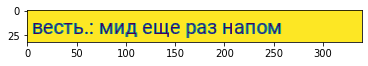

In [10]:
import matplotlib.pyplot as plt

data_transf = [transforms.Grayscale(1),
                 transforms.ToTensor(),
                 transforms.Resize((32, 128)),
                 transforms.Normalize(0.5, 0.25)]

transform = transforms.Compose(data_transf)

img = Image.open('/content/drive/MyDrive/test_imgs/0_a.png')

plt.imshow(img)

img = transform(img).unsqueeze(0)

In [11]:
device = torch.device('cpu')

loaded_chkpnt = torch.load('/content/drive/MyDrive/checkpoints/checkpoint_ep37_less_lr.pth.tar', map_location = device)

model = CRNN_LSTM()

optimizer = optim.Adam(model.parameters(), lr=0.0001)

model.load_state_dict(loaded_chkpnt['state_dict'])
optimizer.load_state_dict(loaded_chkpnt['optimizer'])

model.eval()
with torch.no_grad():
  predictions = model(img)

In [12]:
def decode(pred):
    pred = pred.permute(1, 0, 2).cpu().data.numpy()
    seq = []
    print(pred.shape[0])
    for i in range(pred.shape[0]):
        seq.append(pred_to_string(pred[i]))
    return seq

In [13]:
def pred_to_string(pred):
    alphabet = 'аАбБвВгГдДеЕёЁжЖзЗиИйЙкКлЛмМнНоОпПрРсСтТуУфФхХцЦчЧшШщЩъЪыЫьЬэЭюЮяЯ0123456789-.,: !()"?;'
    seq = []
    for i in range(pred.shape[0]):
        label = np.argmax(pred[i])
        print(label)
        seq.append(label - 1)
    out = []
    for i in range(len(seq)):
        if len(out) == 0:
            if seq[i] != -1:
                out.append(seq[i])
        else:
            if seq[i] != -1 and seq[i] != seq[i - 1]:
                out.append(seq[i])
    out = ''.join(alphabet[i] for i in out)
    return out

In [14]:
decode(predictions.softmax(2))

1
0
0
0
37
39
59
59
0
0
0
29
29
29
29
29
29
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0


['стьна']

Итог:

Реализовал обучение сетки CRNN с лоссом CTC.

В силу ограничений коллаба, и в целом проблем с ним - было очень мало времени на обучение (около 5 часов), чего не хватило даже близко, для адекватного обучения и получения результатов, в последствии нейронка может распозновать только часть символов.

Батч сайз увеличивал до таких размеров как раз из-за ограничений по времени, ЛР пытался тоже поднять, но привело к взрывному градиенту и в последствии уменьшил ЛР.

Также в силу того, что спешил скорее сдать не успел реализовать алгоритм оценки модели и сохранение с лучшими параметрами , вместо каждой второй эпохи, но не имело большого значения, так как времени не хватило снизить лосс и на обучающей выборке.

Попробовал бы дальше исследование с уменьшением батч сайза, увеличения данных и подобрал бы больше разнообразных данных и с различным шумом, также хотелось бы по-больше по эксперементировать с ЛР